# CQF Project - Time Series Analysis and Backtesting

## Pair Trading and VAR analysis applied to Energy Stocks 

### Session Information:

In [1]:
# basic Libraries:
import numpy as np
import pandas as pd
import itertools
import pandas_datareader.data as web # get data
from pip._internal.operations.freeze import freeze

# ML libraries
import scipy.stats as stats
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.tsatools import lagmat
import statsmodels.tsa.stattools # for ADF test and coint function
import statsmodels.api # for OLS
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR

# plot libraries
%matplotlib inline
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pylab

# time series libraries
import datetime
import zmq
import datetime as dt

# Proprietary libraries
from py_utility import *
from VecBacktester_spread import *
from Perf_Stats_Tools import *

Python version and OS info are presented below:

In [2]:
# Python Version and OS info:
%load_ext version_information
%version_information

Software versions
Python 3.7.0 64bit [MSC v.1912 64 bit (AMD64)]
IPython 6.5.0
OS Windows 10 10.0.17134 SP0
Mon Jun 24 15:09:47 2019 GMT Daylight Time

Environment libraries are also detailed below and can be found in **session_environment.txt**

In [3]:
# Environment info:
!pip freeze

absl-py==0.7.0
alabaster==0.7.11
anaconda-client==1.7.2
anaconda-navigator==1.9.2
anaconda-project==0.8.2
appdirs==1.4.3
asn1crypto==0.24.0
astor==0.7.1
astroid==2.0.4
astropy==3.0.4
atomicwrites==1.2.1
attrs==18.2.0
Automat==0.7.0
Babel==2.6.0
backcall==0.1.0
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.6.3
bitarray==0.8.3
bkcharts==0.2
blaze==0.11.3
bleach==2.1.4
bokeh==0.13.0
boto==2.49.0
Bottleneck==1.2.1
certifi==2018.8.24
cffi==1.11.5
chardet==3.0.4
click==6.7
cloudpickle==0.5.5
clyent==1.2.2
colorama==0.3.9
comtypes==1.1.7
conda==4.5.11
conda-build==3.15.1
constantly==15.1.0
contextlib2==0.5.5
cryptography==2.3.1
cycler==0.10.0
Cython==0.28.5
cytoolz==0.9.0.1
dask==0.19.1
datashape==0.5.4
DateTime==4.3
decorator==4.3.0
defusedxml==0.5.0
deprecation==2.0.6
distributed==1.23.1
docutils==0.14
eikon==0.1.13
empyrical==0.5.0
entrypoints==0.2.3
et-xmlfile==1.0.1
fastcache==1.0.2
ffn==0.3.4
filelock==3.0.8
Flask==1.0.2
Flask-Cors==3.0.6
future==0.17.1
gast==0.2.2
gevent=

In [4]:
# Another way:
for requirement in freeze(local_only=True):
    print(requirement)

absl-py==0.7.0
alabaster==0.7.11
anaconda-client==1.7.2
anaconda-navigator==1.9.2
anaconda-project==0.8.2
appdirs==1.4.3
asn1crypto==0.24.0
astor==0.7.1
astroid==2.0.4
astropy==3.0.4
atomicwrites==1.2.1
attrs==18.2.0
Automat==0.7.0
Babel==2.6.0
backcall==0.1.0
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.6.3
bitarray==0.8.3
bkcharts==0.2
blaze==0.11.3
bleach==2.1.4
bokeh==0.13.0
boto==2.49.0
Bottleneck==1.2.1
certifi==2018.8.24
cffi==1.11.5
chardet==3.0.4
click==6.7
cloudpickle==0.5.5
clyent==1.2.2
colorama==0.3.9
comtypes==1.1.7
conda==4.5.11
conda-build==3.15.1
constantly==15.1.0
contextlib2==0.5.5
cryptography==2.3.1
cycler==0.10.0
Cython==0.28.5
cytoolz==0.9.0.1
dask==0.19.1
datashape==0.5.4
DateTime==4.3
decorator==4.3.0
defusedxml==0.5.0
deprecation==2.0.6
distributed==1.23.1
docutils==0.14
eikon==0.1.13
empyrical==0.5.0
entrypoints==0.2.3
et-xmlfile==1.0.1
fastcache==1.0.2
ffn==0.3.4
filelock==3.0.8
Flask==1.0.2
Flask-Cors==3.0.6
future==0.17.1
gast==0.2.2
gevent=

## 1. Data dowload

**Note:** is not necessary to do this so **JUST JUMPT TO SECTION 2** to upload data from CSV or execute the next statement:

In [7]:
# custom function to upload data into hdfs file imported from py_utility.py module:
df = data_load()
df.head(3)

,COP,CVX,SPY,XLE,XOM,COP_d,COP_r,COP_c,CVX_d,CVX_r,CVX_c,SPY_d,SPY_r,SPY_c,XLE_d,XLE_r,XLE_c,XOM_d,XOM_r,XOM_c
1999-12-31,7.294690,18.624716,102.427879,18.649471,23.040768,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,1.000000
2000-01-03,7.032778,17.979708,101.425385,18.283792,22.397268,-0.261912,-0.036565,0.963435,-0.645008,-0.035246,0.964754,-1.002495,-0.009836,0.990164,-0.365679,-0.019803,0.980197,-0.643499,-0.028326,0.971674
2000-01-04,6.896972,17.979708,97.459068,17.939638,21.968271,-0.135806,-0.019499,0.943936,0.000000,0.000000,0.964754,-3.966316,-0.039891,0.950274,-0.344154,-0.019002,0.961195,-0.428997,-0.019340,0.952334


If you want to delve into how the pricing data has been obtained, continue reading:

To obtain the data we can use two storing formats:

**1) HDF5 file:** dict-like object which reads/writes pandas using high performance HDF5 format

In [12]:
# custom function to download data into hdfs file imported from py_utility.py module
# > it stores data into .h5 file on the same directory where the notebook is located
Data_bulk(['XOM','CVX','COP','XLE','SPY'],'1999-12-31','2018-12-31','cqf_data')

In [15]:
# upload data:
data = pd.HDFStore('cqf_data.h5')
data.keys()

['/COP', '/CVX', '/SPY', '/XLE', '/XOM']

In [28]:
# check data:
for i in data.keys():
    print(i)
    print(len(data[i]))
    print(data[i].index[0])
    print(data[i].index[-1])
    print('#'*25)

/COP
4780
1999-12-31 00:00:00
2018-12-31 00:00:00
#########################
/CVX
4780
1999-12-31 00:00:00
2018-12-31 00:00:00
#########################
/SPY
4780
1999-12-31 00:00:00
2018-12-31 00:00:00
#########################
/XLE
4780
1999-12-31 00:00:00
2018-12-31 00:00:00
#########################
/XOM
4780
1999-12-31 00:00:00
2018-12-31 00:00:00
#########################


In [39]:
# close HDF5 database file:
data.close()
data.is_open

False

**2) CSV:** our analysis will use 5 tickers, daily data and less than 20 years so CSV is the simplest option.

In [57]:
df = web.get_data_yahoo(['XOM','CVX','COP','XLE','SPY'],'1999-12-31','2018-12-31')['Adj Close']

In [58]:
df.head()

Symbols,COP,CVX,SPY,XLE,XOM
Date,,,,,
1999-12-31,7.294690,18.624716,102.427879,18.649471,23.040768
2000-01-03,7.032778,17.979708,101.425385,18.283792,22.397268
2000-01-04,6.896972,17.979708,97.459068,17.939638,21.968271
2000-01-05,6.770869,18.302212,97.633377,18.412859,23.165886
2000-01-06,7.003678,19.081606,96.064301,19.122696,24.363516


In [59]:
# store dataframe to csv:
df.to_csv('cqf_data_df.csv', index=True)

## 2. Data Upload


**Project**

The project selected is related to one of the suggested topics: "Time Series Analysis and Backtesting". The author has decided to follow the first Design recommended in the document "Certiﬁcate in Quantitative Finance Final Project Brief" provided to the students by the CQF Institute organization. 

This first design named **"Design 1: Learning’ and Cointegration in Pairs"** covering the next points:

1. Implement concise matrix form estimation for multivariate regression and conduct model speciﬁcation tests for: (a) identifying optimal lag p and (b) stability check.
2. Optionally, test forecasting capability of regression with IRF and Granger Causality.
3. Implement Engle-Granger procedure and use it to identify a cointegrated pair. Estimate relationships both ways to select the appropriate lead variable. ADF test for unit root must be coded and used.
5. Backtest Strategy.



**Data**

A sample of 3 stocks and 2 ETFs has been chosen for the period 2000-2018 using daily data from yahoofinance via Python's pandas_datareader library. The information of the five securities downloaded is shown below:

| Ticker | Name | Weight XLE | Weight SPY |
| --- | --- | --- | --- |
| COP | ConocoPhillips | ~5% | ~0.3% |
| CVX |Chevron Corporation | ~22% | ~1.5% |
| XOM |Exxon Mobil Corporation | ~22% | ~1.5% |
| XLE |Energy Select Sector SPDR | NA | NA |
| SPY |SPDR S&P 500 ETF Trust | NA | NA |

The three stocks belong to the Oil&Gas Integrated industry, part of the Energy Sector (MSCI GSCI Sector Classification). An integrated oil and gas company is a business entity that engages in the exploration, production, refinement and distribution of oil and gas. Hence, an integrated company is more diversified than a pure E&P (exploration & production) firm or a firm specialized in refining crude oil to obtain other products such as petroleum naphtha, gasoline, diesel fuel, asphalt base, heating oil, kerosene, liquefied petroleum gas, jet fuel and fuel oils.

In addition, two ETFs have been added to our sample. On the one hand, Energy Select Sector SPDR seeks to provide an effective representation of the energy sector of the S&P 500 Index. On the other hand, SPDR S&P 500 ETF Trust allows investors to track the S&P 500 stock market index and is the largest ETF in the world.

The frequency of the data is daily with observations ranging from 31/12/1999 to 31/12/2018. 

In [2]:
# custom function to upload data into hdfs file imported from py_utility.py module:
df = data_load()
df.head(3)

,COP,CVX,SPY,XLE,XOM,COP_d,COP_r,COP_c,CVX_d,CVX_r,CVX_c,SPY_d,SPY_r,SPY_c,XLE_d,XLE_r,XLE_c,XOM_d,XOM_r,XOM_c
1999-12-31,7.294690,18.624716,102.427879,18.649471,23.040768,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,1.000000
2000-01-03,7.032778,17.979708,101.425385,18.283792,22.397268,-0.261912,-0.036565,0.963435,-0.645008,-0.035246,0.964754,-1.002495,-0.009836,0.990164,-0.365679,-0.019803,0.980197,-0.643499,-0.028326,0.971674
2000-01-04,6.896972,17.979708,97.459068,17.939638,21.968271,-0.135806,-0.019499,0.943936,0.000000,0.000000,0.964754,-3.966316,-0.039891,0.950274,-0.344154,-0.019002,0.961195,-0.428997,-0.019340,0.952334


## 3. Exploratory Data Analysis

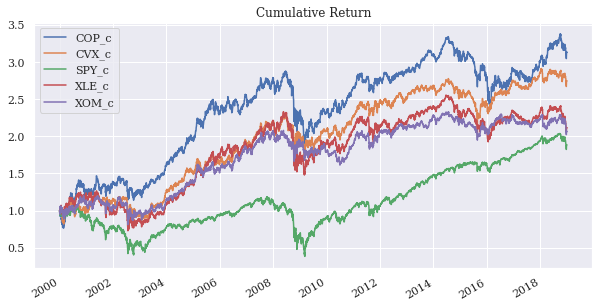

In [6]:
df.filter(regex='_c').plot(figsize=(10,5),title='Cumulative Return')

In [7]:
df.filter(regex='_r').columns

Index(['COP_r', 'CVX_r', 'SPY_r', 'XLE_r', 'XOM_r'], dtype='object')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002D30AB2D5F8>,
      dtype=object)

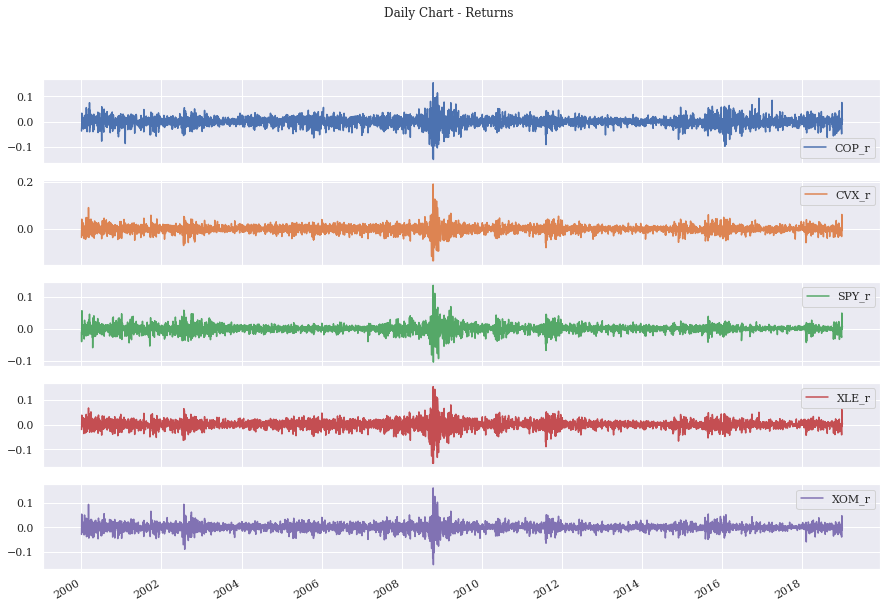

In [8]:
df.filter(regex='_r').plot(subplots=True, figsize=(15,10),title='Daily Chart - Returns')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002D30BD44828>,
      dtype=object)

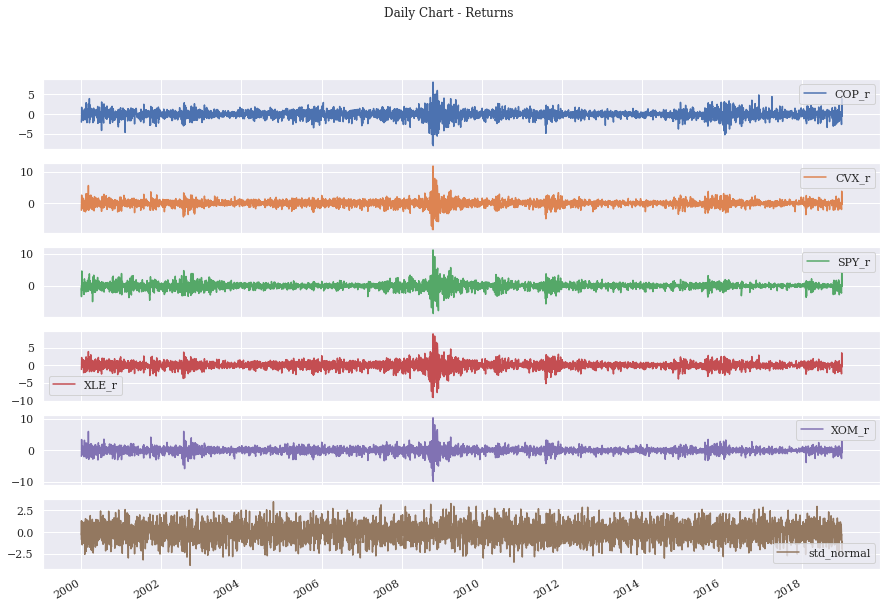

In [9]:
# Standardize returns and add an standard normal variable to compare:
df_std = df.filter(regex='_r').apply(lambda x: (x - np.mean(x))/np.std(x))
df_std['std_normal'] = np.random.standard_normal(len(df_std.index))
df_std.dropna().plot(subplots=True, figsize=(15,10),title='Daily Chart - Returns')

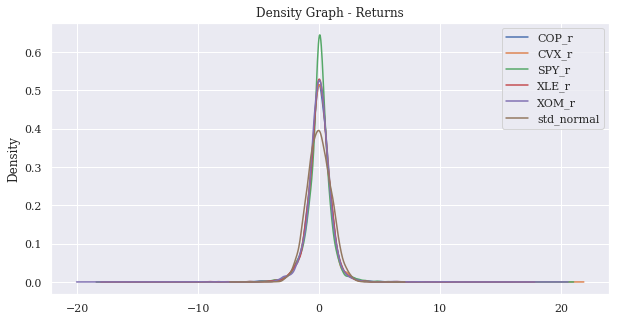

In [10]:
# Standardized Returns Variables Density Graph
df_std.plot(kind='density',figsize=(10,5), title='Density Graph - Returns')

Custom function **adv_describe()** to analyze key stats imported from py_utility.py module:

In [11]:
# Original Returns Data Analysis:
adv_describe(df.filter(regex='_r'), alpha=0.01)

normal test based on D'Agostino and Pearson's  test that combines skew and kurtosis to produce an omnibus test of normality. 


,COP_r,CVX_r,SPY_r,XLE_r,XOM_r
count,4779,4779,4779,4779,4779
mean,0.00045,0.00037,0.00019,0.00023,0.00022
std,0.01892,0.01601,0.01212,0.0172,0.0152
min,-0.14869,-0.13341,-0.10364,-0.156,-0.15027
25%,-0.00901,-0.00776,-0.00476,-0.00807,-0.00725
50%,0.00081,0.00078,0.00063,0.00063,0.00039
75%,0.01092,0.00879,0.00577,0.00934,0.00804
max,0.15365,0.18942,0.13558,0.1525,0.15863
skew,-0.309584,0.0491737,-0.0571121,-0.422637,0.0149614
kurt,5.47089,10.6404,10.4491,9.06688,10.484


In [12]:
# Standardized Returns Data Analysis:
adv_describe(df_std, alpha=0.01)

normal test based on D'Agostino and Pearson's  test that combines skew and kurtosis to produce an omnibus test of normality. 


,COP_r,CVX_r,SPY_r,XLE_r,XOM_r,std_normal
count,4779,4779,4779,4779,4779,4779
mean,0,0,-0,0,-0,0.002
std,1.0001,1.0001,1.0001,1.0001,1.0001,1.00066
min,-7.88418,-8.35481,-8.56654,-9.08539,-9.90165,-3.76645
25%,-0.4999,-0.50766,-0.40837,-0.48289,-0.49193,-0.67726
50%,0.01902,0.02607,0.03696,0.02317,0.01135,-0.01588
75%,0.55384,0.52601,0.46089,0.52976,0.51468,0.673
max,8.09876,11.8072,11.1713,8.85511,10.4224,3.46833
skew,-0.309584,0.0491737,-0.0571121,-0.422637,0.0149614,0.0426786
kurt,5.47089,10.6404,10.4491,9.06688,10.484,-0.0354914


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002D30C2B5BA8>,
      dtype=object)

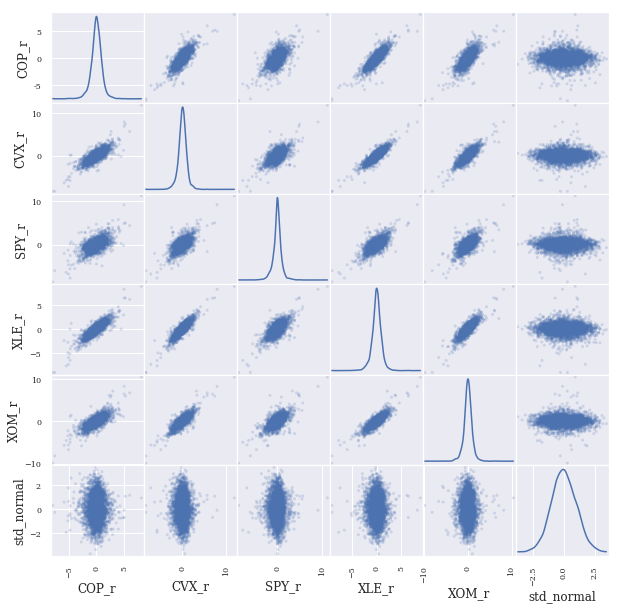

In [13]:
scatter_matrix(df_std, alpha=0.2, figsize=(10, 10), diagonal='kde')

In [14]:
df.filter(regex='_d').corr().round(2)

,COP_d,CVX_d,SPY_d,XLE_d,XOM_d
COP_d,1.00,0.78,0.59,0.84,0.73
CVX_d,0.78,1.00,0.65,0.86,0.81
SPY_d,0.59,0.65,1.00,0.68,0.65
XLE_d,0.84,0.86,0.68,1.00,0.85
XOM_d,0.73,0.81,0.65,0.85,1.00


In [15]:
corr_r = df.filter(regex='_r').corr().round(2)
corr_r

,COP_r,CVX_r,SPY_r,XLE_r,XOM_r
COP_r,1.00,0.79,0.59,0.86,0.74
CVX_r,0.79,1.00,0.65,0.88,0.83
SPY_r,0.59,0.65,1.00,0.70,0.66
XLE_r,0.86,0.88,0.70,1.00,0.85
XOM_r,0.74,0.83,0.66,0.85,1.00


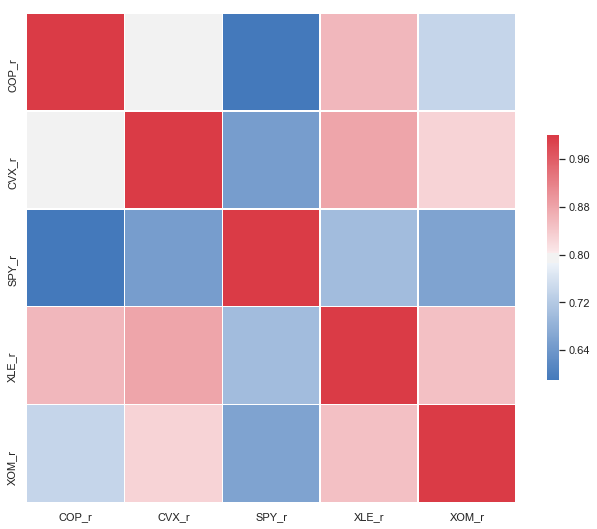

In [16]:
# custom function to plot heatmap imported from py_utility.py module:
heatmap_corr(corr_r,cent=None, dropDuplicates = False ) # if center is set as the average correlation

### Distribution Similarity Tests

https://en.wikipedia.org/wiki/Friedman_test
    
Assumption:

- Observations in each sample are independent and identically distributed (iid).
- Observations in each sample can be ranked.
- Observations across each sample are paired.

Important: Because of the assumption that the test statistic has a chi squared distribution, the p-value is only reliable for n > 10 and more than 6 repeated measurements.

In [17]:
# custom function to test distribution similarity imported from py_utility.py module:
friedman_similarity_test(df)

Ho: Same Distribution


FriedmanchisquareResult(statistic=9.646972676688579, pvalue=0.04681333275335434)

## 4. Implement concise matrix form estimation for multivariate regression and conduct model speciﬁcation tests for: (a) identifying optimal lag p and (b) stability check

VAR(p) models assume that the passed time series are stationary. Non-stationary or trending data can often be transformed to be stationary by first-differencing or some other method. For direct analysis of non-stationary time series, a standard stable VAR(p) model is not appropriate. 

Conducting ADF (Augmented Dickey Fuller) test for stationarity we can confirm that the security returns to be utilized in our VAR(p) model are stationary as p-values seems to be significantly small rejecting the null hypothesis that a unit root is present aka non-stationarity. In addition, security price differences are also tested for unit root existence and the results also are confirming stationarity of the data. Last but not least, security price level data is tested as well and, as expected, the results show significant p-values that force us to do not reject the null hypothesis of existence of unit root.

In [18]:
# ADF test imported from py_utility.py module:
adf_test(df.filter(regex='_r').dropna()) 

Reject Null Hypothesis: Unit Root (Non-Stationary) for p-values < threshold (e.g. 0.01 or 0.05)


,ADF Stat,ADF p-value,Lag,1% CV,5% CV,10% CV
COP_r,-52.6552,0.0,1,-2.5662,-1.9411,-1.6168
CVX_r,-28.9776,0.0,5,-2.5662,-1.9411,-1.6168
SPY_r,-33.3905,0.0,4,-2.5662,-1.9411,-1.6168
XLE_r,-33.4838,0.0,4,-2.5662,-1.9411,-1.6168
XOM_r,-33.9273,0.0,4,-2.5662,-1.9411,-1.6168


In [19]:
adf_test(df.filter(regex='_d').dropna())

Reject Null Hypothesis: Unit Root (Non-Stationary) for p-values < threshold (e.g. 0.01 or 0.05)


,ADF Stat,ADF p-value,Lag,1% CV,5% CV,10% CV
COP_d,-71.9650,0.0,0,-2.5662,-1.9411,-1.6168
CVX_d,-28.6403,0.0,5,-2.5662,-1.9411,-1.6168
SPY_d,-32.7963,0.0,4,-2.5662,-1.9411,-1.6168
XLE_d,-28.7683,0.0,5,-2.5662,-1.9411,-1.6168
XOM_d,-33.4440,0.0,4,-2.5662,-1.9411,-1.6168


In [20]:
adf_test(df[['COP','CVX','SPY','XLE','XOM']].dropna())

Reject Null Hypothesis: Unit Root (Non-Stationary) for p-values < threshold (e.g. 0.01 or 0.05)


,ADF Stat,ADF p-value,Lag,1% CV,5% CV,10% CV
COP,0.5259,0.8308,1,-2.5662,-1.9411,-1.6168
CVX,0.9291,0.9058,5,-2.5662,-1.9411,-1.6168
SPY,1.9087,0.9875,5,-2.5662,-1.9411,-1.6168
XLE,0.0707,0.7073,2,-2.5662,-1.9411,-1.6168
XOM,0.3680,0.7928,5,-2.5662,-1.9411,-1.6168


#### VAR Model Theoretical Framework

The matrix form of the VAR model is as it follows:

$$\begin{equation*} y_t = c + A_1 y_{t-1} + A_2 y_{t-1} + \cdots + A_p y_{t-p} + A_q y_{t-q} + e_t  \end{equation*}$$

Where:
- K  = number of endogeneous variables
- y<sub>t</sub> = K x 1 array
- A = K x K  matrix
- e<sub>t</sub> = model error

Writing a more comprehensive matrix notation aka large matrix notation:

$
\begin{vmatrix}
\ y_{1,t} \\
y_{2,t}  \\
\vdots \\
y_{k,t}
\end{vmatrix} = 
\begin{vmatrix}
\ c_{1} \\
c_{2}  \\
\vdots \\
c_{k}
\end{vmatrix} +
\begin{vmatrix}
\ a_{1,1}^{1} &  a_{1,2}^{1} & \dots & a_{1,k}^{1} \\
a_{2,1}^{1} &  a_{2,2}^{1} & \dots & a_{2,k}^{1} \\
\vdots &  \vdots & \ddots & \vdots\\
a_{k,1}^{1} &  a_{k,2}^{1} & \dots & a_{k,k}^{1}
\end{vmatrix}
\begin{vmatrix}
\ y_{1,t-1} \\
y_{2,t-1}  \\
\vdots \\
y_{k,t-1}
\end{vmatrix} + \dots + 
\begin{vmatrix}
\ a_{1,1}^{p} &  a_{1,2}^{p} & \dots & a_{1,k}^{p} \\
a_{2,1}^{p} &  a_{2,2}^{p} & \dots & a_{2,k}^{p} \\
\vdots &  \vdots & \ddots & \vdots\\
a_{k,1}^{p} &  a_{k,2}^{p} & \dots & a_{k,k}^{p}
\end{vmatrix}
\begin{vmatrix}
\ y_{1,t-p} \\
y_{2,t-p}  \\
\vdots \\
y_{k,t-p}
\end{vmatrix} + 
\begin{vmatrix}
\ e_{1,t} \\
e_{2,t}  \\
\vdots \\
e_{k,t}
\end{vmatrix}
$

This expression can be also rewrite using a concise matrix notation which includes T+1 observations y<sub>0</sub> through y<sub>T</sub>: 

$$ Y = BZ + U $$

Where:

$$
Y = \begin{vmatrix}
\ y_{p} & y_{p+1} & \dots & y_{T}
\end{vmatrix}=
\begin{vmatrix}
\ y_{1,p} &  y_{1,p+1} & \dots & y_{1,T} \\
y_{2,p} &  y_{2,p+1} & \dots & y_{2,T} \\
\vdots &  \vdots & \ddots & \vdots\\
y_{k,p} &  y_{k,p+1} & \dots & y_{k,T}
\end{vmatrix}
$$



$$
B = \begin{vmatrix}
\ c & A_1 & A_2 & \dots & A_p
\end{vmatrix}=
\begin{vmatrix}
\ c_1 &  a_{1,1}^{1} & a_{1,2}^{1} & \dots & a_{1,k}^{1} & \dots & a_{1,1}^{p} & a_{1,2}^{p} & \dots & a_{1,k}^{p} \\
 c_2 &  a_{2,1}^{1} & a_{2,2}^{1} & \dots & a_{2,k}^{1} & \dots & a_{2,1}^{p} & a_{2,2}^{p} & \dots & a_{2,k}^{p} \\
\vdots &  \vdots & \ddots & \vdots\\
c_k &  a_{k,1}^{1} & a_{k,2}^{1} & \dots & a_{k,k}^{1} & \dots & a_{k,1}^{p} & a_{k,2}^{p} & \dots & a_{k,k}^{p}
\end{vmatrix}
$$



$$
Z = \begin{vmatrix}
\ 1 &  1 & \dots & 1 \\
 y_(p-1) &  y_(p) & \dots & y_(T-1)\\
 y_(p-2) &  y_(p-1) & \dots & y_(T-2)\\
\vdots &  \vdots & \ddots & \vdots\\
 y_(0) &  y_(1) & \dots & y_(T-p)\\
\end{vmatrix}=
\begin{vmatrix}
\ 1 &  1 & \dots & 1 \\
y_{1,p-1} &  y_{1,p} & \dots & y_{1,T-1}\\
y_{2,p-1} &  y_{2,p} & \dots & y_{2,T-1}\\
\vdots &  \vdots & \ddots & \vdots\\
y_{k,p-1} &  y_{k,p} & \dots & y_{k,T-1}\\
y_{1,p-2} &  y_{1,p-1} & \dots & y_{1,T-2}\\
y_{2,p-2} &  y_{2,p-1} & \dots & y_{2,T-2}\\
\vdots &  \vdots & \ddots & \vdots\\
y_{k,p-2} &  y_{k,p-1} & \dots & y_{k,T-2}\\
\vdots &  \vdots & \ddots & \vdots\\
y_{1,0} &  y_{1,1} & \dots & y_{1,T-p}\\
y_{2,0} &  y_{2,1} & \dots & y_{2,T-p}\\
\vdots &  \vdots & \ddots & \vdots\\
y_{k,0} &  y_{k,1} & \dots & y_{k,T-p}
\end{vmatrix}
$$


$$
U = \begin{vmatrix}
\ e{p} & e{p+1} & \dots & e_{T}
\end{vmatrix}=
\begin{vmatrix}
\ e_{1,p} &  e_{1,p+1} & \dots & e_{1,T} \\
e_{2,p} &  e_{2,p+1} & \dots & e_{2,T} \\
\vdots &  \vdots & \ddots & \vdots\\
e_{k,p} &  e_{k,p+1} & \dots & e_{k,T}
\end{vmatrix}
$$

Where:

- Y is a K x (T+1) matrix
- B is a K x (K*P +1) matrix
- Z is a (K*P + 1) x (T +1) matrix
- U is a K x (T+1) matrix

Hence, the solution for a VAR(p) model coefficients in B matrix can be obtained easily using, for instance, OLS (ordinary least squares estimation) and the expression:

$$ \hat{B} = (Z^{T} Z)^{-1} Z^{T} Y $$

#### Finding Optimal P Lags

After confirming stationarity of the returns calculated for our securities, it is necessary to step forward to the next step i.e. calculate the VAR(p) optimal number of lags.

VAR(p) set up needs to state an optimal lag p to be estimated beforehand. The methodology is pretty straightforward consisting on testing various lags for p and select the value that minimizes a function called the “Information Criterion”. Several authors have come up with different alternatives to obtain an information criterion (IC) that optimizes model selection such as Akaike Information Criterion (AIC), Schwarz-Bayes Criterion (SBC) – also known as the Bayesian Information Criterion (BIC) – Akaike’s Final Prediction Error Criterion (FPE), and Hannan-Quinn Criterion (HQ). 

Each criterion is a sum of two terms, one that characterizes the entropy rate or prediction error of the model, and a second term that characterizes the number of freely estimated parameters in the model (which increases with increasing model order). By minimizing both terms, we seek to identify a model that does not overfit the data with too many parameters(parsimonius) without neglecting modelling accuracy.

Four main IC are detailed below along with their mathematical expression (Lütkepohl, 2005):

<img src="IC_comp.png">

Where:
- $$ \log( \lvert(\sum_)^{\sim}(p) \rvert $$ is is the logarithm of the determinant of the estimated noise covariance matrix (prediction error) for a VAR model of order p.

- $$ T' = T*N $$  is the total number of datapoints used to fit the model.

- $$ pM^2 = n*(n*j+1) $$ with n=number of securities (time series) and j=lag

Each IC is an estimate of a constant plus the relative distance between the unknown true likelihood function of the data and the fitted likelihood function of the model. Hence, for each method,the best model minimizes IC and, as a consequence, it is the one minimizing the residuals too and, thereby, the determinant of the covariance matrix will be approximately zero:

$$ p_{optimal} = \arg\min_p{IC(p) } $$ 

The key difference between the criteria is how severely each penalizes model complexity (the second term). AIC and SBC are the most widely used, but SBC more heavily penalizes larger model orders. For moderate and large , FPE and AIC are essentially equivalent; however, FPE may outperform AIC for very small sample sizes. HQ penalizes high model orders more heavily than AIC but less than SBC. Both SBC and HQ are consistent estimators, yet this cannot be said of AIC and FPE.


In [21]:
# Using StatsModels library:
model= VAR(df.filter(regex='_r').dropna())

C:\Users\Carlo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [22]:
#optiomal p lags:
lag = model.select_order(maxlags=20)
lag.aic # 15 lags is the optimal based on Minimizing AIC (Akaike Information Criteria)

15

Optimal lag selection using a single IC might be dangerous as the optimal lag for both AIC and FPE (p=15) yields a very complex model that can be prone to overfitting. When considering BIC and HQIC's optimal lags the models are much less complex. As a result, an IC score ranking is calculated (the higher the IC, the higher the score) to gather different insights from the multiple IC considered and the results were favouring the use of a VAR(2) 

In [23]:
lag.summary()

,AIC,BIC,FPE,HQIC
0,-46.51,-46.50*,6.331e-21,-46.51
1,-46.54,-46.50,6.132e-21,-46.53
2,-46.55,-46.48,6.056e-21,-46.53*
3,-46.55,-46.44,6.075e-21,-46.51
4,-46.55,-46.41,6.061e-21,-46.50
5,-46.55,-46.37,6.073e-21,-46.49
6,-46.55,-46.34,6.087e-21,-46.47
7,-46.55,-46.30,6.083e-21,-46.46
8,-46.55,-46.27,6.071e-21,-46.45
9,-46.55,-46.24,6.050e-21,-46.44


In [24]:
# Ranking
ic_df = pd.DataFrame(lag.ics)
#ic_df.sort_values('aic')
ic_rank = ic_df.rank(axis=0)
ic_rank['score'] = ic_rank.mean(axis=1)
ic_rank.sort_values('score')

,aic,bic,hqic,fpe,score
2,7.0,3.0,1.0,7.0,4.50
4,8.0,5.0,5.0,8.0,6.50
10,5.0,11.0,11.0,5.0,8.00
5,10.0,6.0,6.0,10.0,8.00
9,6.0,10.0,10.0,6.0,8.00
3,13.0,4.0,3.0,13.0,8.25
15,1.0,16.0,16.0,1.0,8.50
8,9.0,9.0,9.0,9.0,9.00
16,2.0,17.0,17.0,2.0,9.50
17,3.0,18.0,18.0,3.0,10.50


Firstly, let's use run the proprietary VAR model function coded from **py_utility.py**:

In [25]:
fit_p = p_VAR(df.filter(regex='_r').dropna(),p=2,constant=True)
fit_p

,COP_r,CVX_r,SPY_r,XLE_r,XOM_r
const,0.000509,0.000433,0.000233,0.000291,0.000303
L1.COP_r,-0.018881,-0.018886,0.014031,0.012353,-0.033281
L1.CVX_r,-0.032208,-0.062964,-0.026003,-0.046691,-0.012941
L1.SPY_r,0.030181,-0.017600,-0.024006,0.062370,-0.076478
L1.XLE_r,0.051456,0.068997,0.002635,-0.025375,0.037449
L1.XOM_r,-0.083986,-0.056896,-0.042198,-0.045301,-0.060522
L2.COP_r,-0.057397,-0.020381,-0.006636,-0.030388,-0.028990
L2.CVX_r,-0.003384,-0.070288,-0.029997,-0.039309,-0.016712
L2.SPY_r,0.023969,0.017239,-0.067779,0.014367,0.003271
L2.XLE_r,0.021542,0.040624,0.014148,0.021008,0.004973


Let's check the results with those from StatsModel library:

In [26]:
# Using StatsModels library:
model= VAR(df.filter(regex='_r').dropna())

C:\Users\Carlo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [27]:
fit = model.fit(maxlags= 2,ic='aic', trend='c')

In [28]:
fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 24, Jun, 2019
Time:                     15:13:55
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -46.4369
Nobs:                     4777.00    HQIC:                  -46.4852
Log likelihood:           77256.1    FPE:                6.31473e-21
AIC:                     -46.5114    Det(Omega_mle):     6.24252e-21
--------------------------------------------------------------------
Results for equation COP_r
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.000509         0.000273            1.861           0.063
L1.COP_r        -0.018881         0.028326           -0.667           0.505
L1.CVX_r        -0.032208         0.038201           -0.843           0.399
L1.S

In [29]:
fit.params

,COP_r,CVX_r,SPY_r,XLE_r,XOM_r
const,0.000509,0.000433,0.000233,0.000291,0.000303
L1.COP_r,-0.018881,-0.018886,0.014031,0.012353,-0.033281
L1.CVX_r,-0.032208,-0.062964,-0.026003,-0.046691,-0.012941
L1.SPY_r,0.030181,-0.017600,-0.024006,0.062370,-0.076478
L1.XLE_r,0.051456,0.068997,0.002635,-0.025375,0.037449
L1.XOM_r,-0.083986,-0.056896,-0.042198,-0.045301,-0.060522
L2.COP_r,-0.057397,-0.020381,-0.006636,-0.030388,-0.028990
L2.CVX_r,-0.003384,-0.070288,-0.029997,-0.039309,-0.016712
L2.SPY_r,0.023969,0.017239,-0.067779,0.014367,0.003271
L2.XLE_r,0.021542,0.040624,0.014148,0.021008,0.004973


The table below subtracts the coefficients from the SM library table from those obtained by the proprietary code. It can be confirmed that the results for both approaches are identical:

In [30]:
# Checking:
(fit.params - fit_p).round(3)

,COP_r,CVX_r,SPY_r,XLE_r,XOM_r
const,-0.0,-0.0,-0.0,-0.0,-0.0
L1.COP_r,-0.0,-0.0,0.0,0.0,-0.0
L1.CVX_r,0.0,-0.0,0.0,0.0,0.0
L1.SPY_r,-0.0,-0.0,0.0,0.0,-0.0
L1.XLE_r,-0.0,0.0,-0.0,-0.0,0.0
L1.XOM_r,0.0,0.0,0.0,0.0,-0.0
L2.COP_r,-0.0,-0.0,-0.0,-0.0,0.0
L2.CVX_r,0.0,0.0,-0.0,0.0,-0.0
L2.SPY_r,0.0,0.0,-0.0,-0.0,-0.0
L2.XLE_r,0.0,-0.0,0.0,-0.0,-0.0


A VAR(2) model results highlight a reasonable high correlation between the residuals of the securities and provide encouraging expectations for a cointegrated relationship between a pair of securities. 

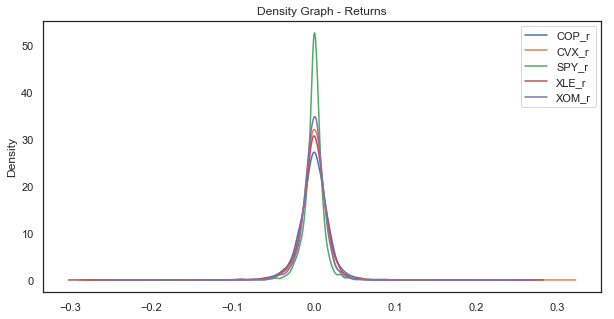

In [31]:
fit.resid.plot(kind='density',figsize=(10,5), title='Density Graph - Returns')

In [32]:
# custom function to analyze key stats imported from py_utility.py module:
adv_describe(fit.resid, alpha=0.05)

normal test based on D'Agostino and Pearson's  test that combines skew and kurtosis to produce an omnibus test of normality. 


,COP_r,CVX_r,SPY_r,XLE_r,XOM_r
count,4777,4777,4777,4777,4777
mean,0,0,0,0,0
std,0.01885,0.01593,0.01204,0.0171,0.01503
min,-0.14317,-0.13617,-0.09408,-0.15604,-0.13579
25%,-0.0096,-0.00791,-0.00501,-0.00826,-0.00744
50%,0.00053,0.00049,0.00059,0.00047,0.00041
75%,0.01046,0.00848,0.00558,0.00916,0.00791
max,0.1342,0.16997,0.12447,0.13681,0.13473
skew,-0.346195,-0.10574,-0.205981,-0.465245,-0.250206
kurt,4.92735,9.10851,9.03467,7.92495,8.41674


VAR(2) model residuals seems to have much higher kurtosis and higher-than-average skew than the normal distribution making it poor model to be used for a purpose other than gaining explanatory power about the features. Q-Q plots below show how fat tails are present in our model residuals.

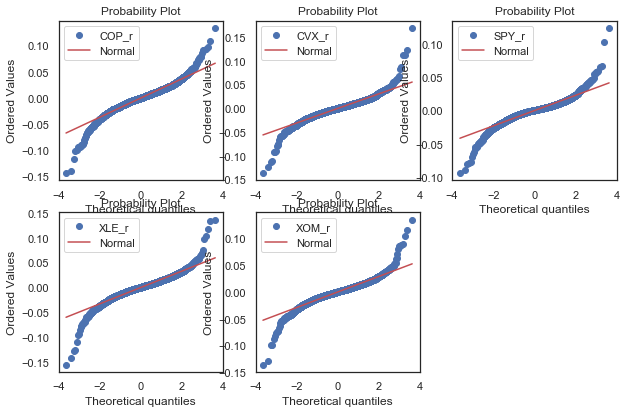

In [33]:
n = len(fit.resid.columns)
for i,j in enumerate(fit.resid.columns):
    exec('x_'+j+'='+'plt.subplot(3,3,'+str(i+1)+')')
    x= fit.resid[j]
    res = stats.probplot(x, plot=eval('x_'+j))
    eval('x_'+j).figure.set_size_inches(10,10)
    plt.legend([j,'Normal'],loc='best')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002D311033BA8>,
      dtype=object)

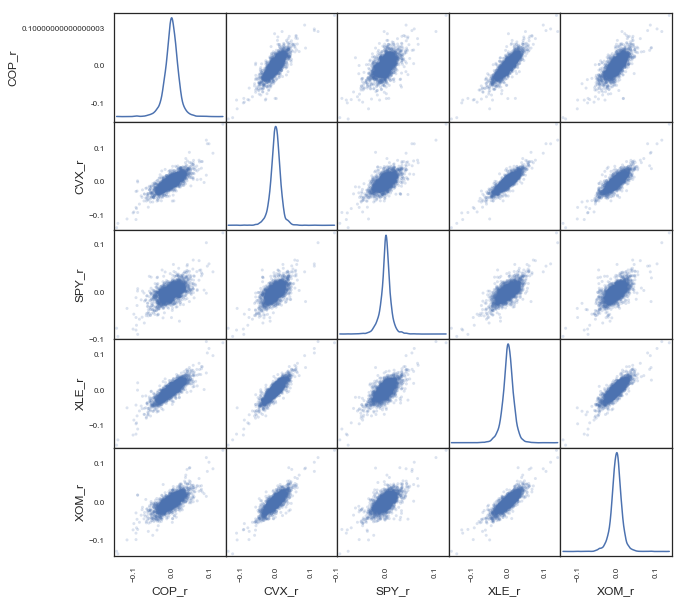

In [34]:
scatter_matrix(fit.resid, alpha=0.2, figsize=(10, 10), diagonal='kde')

In [4]:
def acf_plot(ts, lags_=40):
        ts_ = pd.Series(ts)
        list1 = []
        for i in range(min(len(ts), lags_)):
            list1.append(ts_.autocorr(i))
        df = pd.DataFrame(list1, columns=['ts'])
        df['ts'].plot.bar()
        plt.title('Autocorrel Plot')
        plt.axhline(np.std(list1))
        plt.axhline(-np.std(df.dropna()['ts']), c='g')
        plt.axhline(np.std(df.dropna()['ts']), c='g')
        plt.axhline(-2 * np.std(df.dropna()['ts']), c='r')
        plt.axhline(2 * np.std(df.dropna()['ts']), c='r')

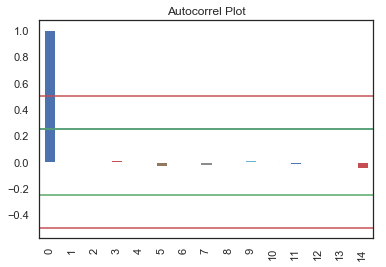

In [36]:
acf_plot(fit.resid['COP_r'], lags_=15)

Using ADF test to check if the VAR(2) model residuals are stationary confirm that we can reject the unit root null hypothesis: 

In [37]:
adf_test(fit.resid)

Reject Null Hypothesis: Unit Root (Non-Stationary) for p-values < threshold (e.g. 0.01 or 0.05)


,ADF Stat,ADF p-value,Lag,1% CV,5% CV,10% CV
COP_r,-69.0456,0.0,0,-2.5662,-1.9411,-1.6168
CVX_r,-28.1499,0.0,5,-2.5662,-1.9411,-1.6168
SPY_r,-69.0690,0.0,0,-2.5662,-1.9411,-1.6168
XLE_r,-32.4648,0.0,4,-2.5662,-1.9411,-1.6168
XOM_r,-32.3506,0.0,4,-2.5662,-1.9411,-1.6168


Last but not least, coefficients stability are tested by requiring eigenvalues of each relationship matrix A to be inside the unit circle(<1). A reminder of the VAR(p) model in terms of A matrices is shown next:

$$\begin{equation*} y_t = c + A_1 y_{t-1} + A_2 y_{t-1} + \cdots + A_p y_{t-p} + A_q y_{t-q} + e_t  \end{equation*}$$

Hence, VAR model satisfies stability condition when:

$$ |\lambda I - A | = 0$$

Using the VAR(2) model via SM library the results are positive confirming the condition above of coefficient stability in our VAR(2) model. 

In [38]:
fit.is_stable()

True

##  5. Test forecasting capability of regression with IRF and Granger Causality

**Impulse responses aka IFR** are the estimated responses to a unit impulse in one of the variables. They are computed in practice using the MA(∞) representation of the VAR(p) process:

$$Y_t = \eta + \sum_{n=0}^{\infty} \phi_i*e_{t-i} $$ 

Or using a matrix form with two variables y<sub>t</sub> and z<sub>t</sub>:

$
\begin{vmatrix}
\ y_{t} \\
y_{t}  \\
\end{vmatrix} = 
\begin{vmatrix}
\ c_{y} \\
c_{z}  \\
\end{vmatrix} +
\begin{vmatrix}
\ a_{y,y} &  a_{y,z} \\
\ a_{z,y} &  a_{z,z}
\end{vmatrix}
\begin{vmatrix}
\ y_{t-1} \\
z_{t-1}  \\
\end{vmatrix} + 
\begin{vmatrix}
\ e_{y,t} \\
e_{z,t}
\end{vmatrix}
$

MA(∞) representation of this matrix form VAR process is:

$
\begin{vmatrix}
\ y_{t} \\
y_{t}  \\
\end{vmatrix} = 
\begin{vmatrix}
\ \bar{y} \\
\bar{z}  \\
\end{vmatrix} +
\sum_{i=0}^{\infty}
\begin{vmatrix}
\ a_{y,y} &  a_{y,z} \\
\ a_{z,y} &  a_{z,z}
\end{vmatrix} 
\begin{vmatrix}
\ e_{y,t-i} \\
e_{z,t-i}
\end{vmatrix}
$

The moving-average representation is important because it allows examining the interaction between the different dependent variables e.g. y<sub>t</sub> and z<sub>t</sub> sequences. The coefficients a are used to generate the effects of shocks during the stated number of periods.

Our VAR(2) exhibited significantly high correlation between residuals. In other words, IRF assumption that shocks occur isolatedly i.e. only one variable experiences a shock on a period  - is not realistic according to our results. In fact, financial markets are featured by tail-risk events during which variables tend to break historical correlation rules of thumb and misbehave increasing their correlations punctually. In this scenarios IRF analysis using MA expression is very useful as an orthogonalised transformation is carried out to obtain IRF coefficients that contain the aforementioned correlation effect. VAR model therefore is transformed into the next expression: 

$$Y_t = \Theta_0 w_{t} + \Theta_{1} w_{t-1}++ \Theta_{2} w_{t-2} $$ 

Where:
$$ \Omega = P P^{-1} \text{is a Cholesky decomposition} $$ 
$$ \text{P is a lower triangular matrix}$$
$$\Theta_i = \Psi_i P $$
$$ w_t = P^{-1} e_t $$
$$ E(w_t w_t^{-1}) = I_N $$

The results for orthogonalized IRF are shown below and point out a significant fade away effect after the initial impulse across the board for both marginal and cumulative shocks for a period of 5 days:

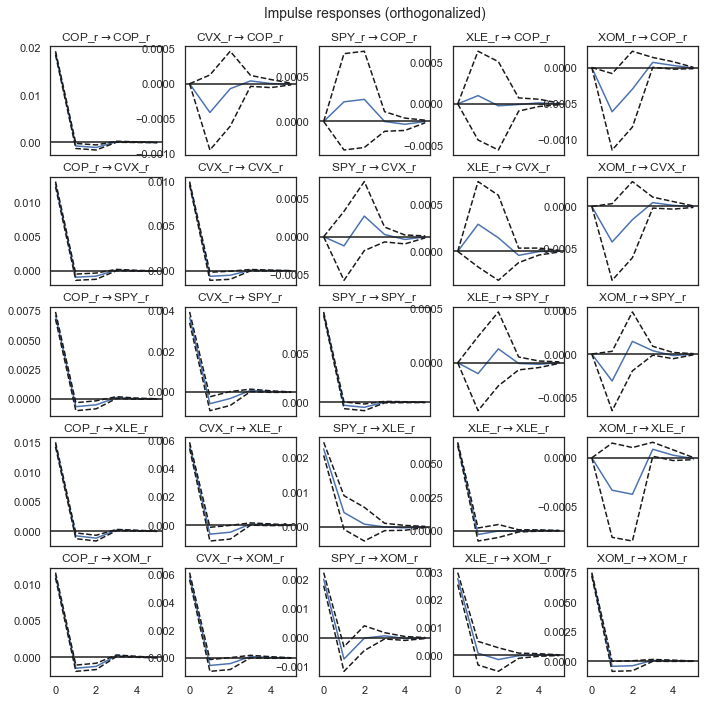

In [39]:
irf = fit.irf(5)
imp_r = irf.plot(orth=True)

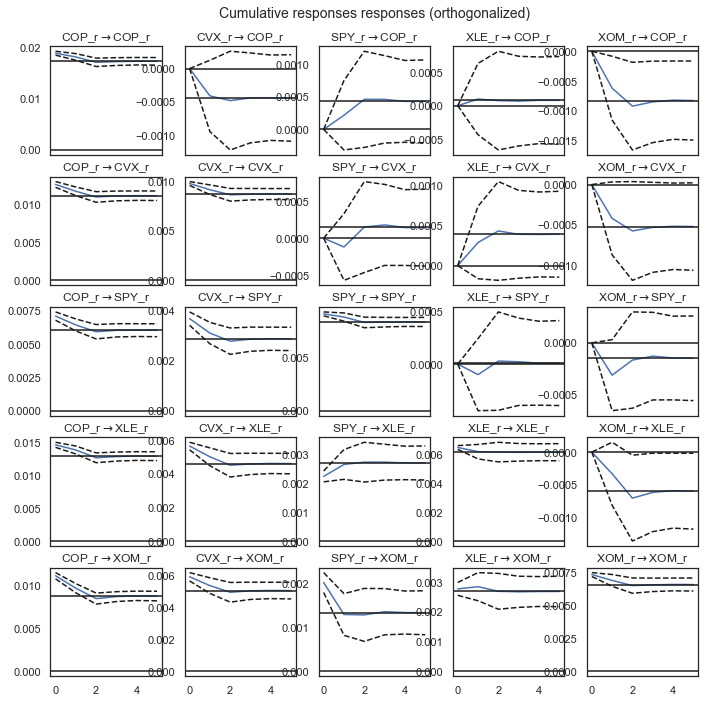

In [40]:
imp_c = irf.plot_cum_effects(orth=True)

**Granger causality test** is a statistical hypothesis test for determining whether one time series is useful in forecasting another, first proposed in 1969.

A "causing" series is said to **Granger-cause*** a "caused" time series if it can be shown, usually through a series of t-tests and F-tests on lagged values of the "causing" (and with lagged values of the "caused" also included), that those "causing" values provide statistically significant information about future values of the "caused" time series.

The key pitfalls of Granger Causality test are:
1. Empirical studies have found a variable "Granger-cause" another variable when both variables are non-fundamentally related e.g. increase of frogs in a lake in the US with the increase in coca cola sales.
2. Granger causality does not account for latent confounding effects i.e. a third variable affecting both "causing" and "caused" variables making Granger Causality test results spurious.
3. Granger causality test does not capture instantaneous and non-linear causal relationships.
4. Granger causality test works under the assumption that all the VAR variables are stationary.

For our purposes, Granger Causality test may be a good proxy to identify significant pair directions as our fundamental analysis to test pairs (stocks within the O&G Integrated industry) and Engle-Granger test procedure will tackle most of the disadvantages aforementioned. The null hypothesis is that the coefficients corresponding to past values of the “causing” variable are zero i.e. the null hypothesis for the equation below will be: 

$$Ho: x_{t-p} = … = x_{t-q} = 0$$

$$ y_t = a_0+a_1 y_{t-1} + a_2 y_{t-2} + a_m y_{t-m} + b_px_{t-p}+ ... + + b_qx_{t-q} + error_t$$

Where p is the shortest, and q is the longest, lag length for which the lagged value of x is significant.

#### Global VAR variables causality test:

In [84]:
fit = model.fit(maxlags= 15,ic='aic', trend='c')

In [85]:
alpha=0.01
print('Ho: VAR variables do not impact')
for i in fit.names:
    names = [x for x in fit.names if x!=i]
    granger = fit.test_causality(i,names)
    pval = granger.pvalue
    conclusion = 'Reject Ho' if pval<0.05 else 'Do not Reject Ho' 
    print(i, granger.pvalue,conclusion)

Ho: VAR variables do not impact
COP_r 4.858192704568109e-06 Reject Ho
CVX_r 5.311126918013791e-05 Reject Ho
SPY_r 1.8312347666123694e-08 Reject Ho
XLE_r 2.3854126879855964e-07 Reject Ho
XOM_r 1.9893691057862615e-10 Reject Ho


#### One-to-One VAR causality test:

In [86]:
alpha = 0.01
df_g = pd.DataFrame()
print('Ho: Causing does not impact Caused')
for i in fit.names:
    for j in fit.names:
        if i==j:
            continue
        else:
            granger = fit.test_causality(i,j)
            pval = round(granger.pvalue, 5)
            conclusion = 'Reject Ho' if pval<alpha else 'Do not Reject Ho' 
            df_temp = pd.DataFrame([[i,j,pval]],columns=['caused','causing','pvalue'])
            df_g = df_g.append(df_temp, ignore_index=True)
            df_g['caused-causing'] = df_g['caused']+'-'+df_g['causing']
            df_g.set_index('caused-causing',drop=True, inplace=True)
            print('caused:',i,'|','causing:',j, round(granger.pvalue,3),conclusion)


Ho: Causing does not impact Caused
caused: COP_r | causing: CVX_r 0.312 Do not Reject Ho
caused: COP_r | causing: SPY_r 0.016 Do not Reject Ho
caused: COP_r | causing: XLE_r 0.03 Do not Reject Ho
caused: COP_r | causing: XOM_r 0.0 Reject Ho
caused: CVX_r | causing: COP_r 0.757 Do not Reject Ho
caused: CVX_r | causing: SPY_r 0.001 Reject Ho
caused: CVX_r | causing: XLE_r 0.006 Reject Ho
caused: CVX_r | causing: XOM_r 0.0 Reject Ho
caused: SPY_r | causing: COP_r 0.091 Do not Reject Ho
caused: SPY_r | causing: CVX_r 0.032 Do not Reject Ho
caused: SPY_r | causing: XLE_r 0.003 Reject Ho
caused: SPY_r | causing: XOM_r 0.0 Reject Ho
caused: XLE_r | causing: COP_r 0.634 Do not Reject Ho
caused: XLE_r | causing: CVX_r 0.112 Do not Reject Ho
caused: XLE_r | causing: SPY_r 0.0 Reject Ho
caused: XLE_r | causing: XOM_r 0.0 Reject Ho
caused: XOM_r | causing: COP_r 0.269 Do not Reject Ho
caused: XOM_r | causing: CVX_r 0.404 Do not Reject Ho
caused: XOM_r | causing: SPY_r 0.0 Reject Ho
caused: XOM_r |

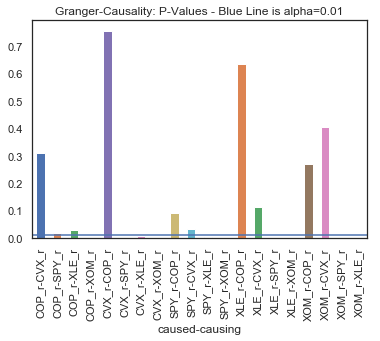

In [87]:
df_g['pvalue'].plot(kind='bar', title='Granger-Causality: P-Values - Blue Line is alpha=0.01')
plt.axhline(alpha)

In [88]:
# Only significant causing>Caused Pairs:
df_sig = df_g[df_g['pvalue']<alpha]
df_sig

,caused,causing,pvalue
caused-causing,,,
COP_r-XOM_r,COP_r,XOM_r,0.00010
CVX_r-SPY_r,CVX_r,SPY_r,0.00053
CVX_r-XLE_r,CVX_r,XLE_r,0.00594
CVX_r-XOM_r,CVX_r,XOM_r,0.00021
SPY_r-XLE_r,SPY_r,XLE_r,0.00260
SPY_r-XOM_r,SPY_r,XOM_r,0.00005
XLE_r-SPY_r,XLE_r,SPY_r,0.00005
XLE_r-XOM_r,XLE_r,XOM_r,0.00042
XOM_r-SPY_r,XOM_r,SPY_r,0.00001


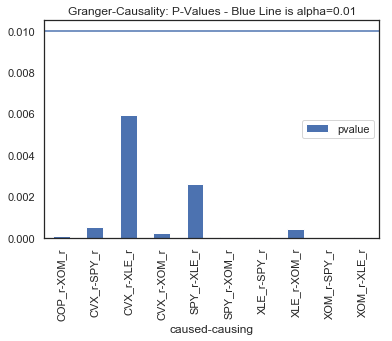

In [89]:
df_sig.plot(kind='bar', title='Granger-Causality: P-Values - Blue Line is alpha=0.01')
plt.axhline(alpha)

##  6. Implement Engle-Granger procedure and use it to identify a cointegrated pair

Two or more variables are said to be cointegrated when there is a linear combination of them that has a lower order of integration, then the series are said to be cointegrated and the residual of the linear combination regression is stationary i.e. two or more series are cointegrated if a linear combination exists which makes the residuals integrated of order zero I(0). 

Cointegration testing is conducted in practice using 3 main methods: Engle–Granger two-step method, Johansen method (JM) and Phillips–Ouliaris (PO) test. As suggested by CQF project guidelines, Engle–Granger (EG) will be here to test a bivariate cointegration relationship. This method is based on testing that the residuals from the regression model between the securities y and x shown below are stationary:

$$ y_t - \beta x_t = u_t $$

JM controls for for more than one cointegrating relationship (multivariate cointegration) hinging on asymptotic properties to be reliable i.e. small samples will yield spurious results. Last but not least, PO is a better choice when dealing with small samples tackling the problem that residual-based unit root tests applied to the estimated cointegrating residuals do not have the usual Dickey–Fuller distributions under the null hypothesis of no-cointegration.

As mentioned before, EG will be used in this project in order to ascertain whether or not 2 securities in our sample are cointegrated:
- **Step 1: Obtain fitted residuals to conduct ADF test (Stationarity Test)**
- **Step 2: ECM using residuals from Step 1**

The training sample to be considered will be the first two thirds of data from the total period 2000-2018 i.e. sample ranging from 31st December 1999 to 30th April 2013. Moreover, a 5% significance level is used to filter p-values obtained from ADF tests in order to shortlist relevant pair cointegration combinations. 

For Step 1 a a proprietarily coded function **coint_test_bulk()** is imported from **py_utility.py** to analyze cointegration as required by CQF project guidelines. Moreover, StatsModels statistic is included from StatsModels library in order to validate and double-check results obtained from the proprietary function. Firstly, proprietary code is used to run step 1 as required by CQF guidelines. 

In [9]:
# Parameters set up
start =  '1999-12-31'
end = '2013-04-30'
nobs = len(df[start:end])
max_l =  int(round((12*nobs/100)**(0.25),0)) # Schwert (1989) optimal max_lag ADF = (12*T/100)^0.25
alpha =0.01

#### 1. ADF Test with Proprietary Code 

Let's first explore a single pair (XOM, COP):

In [10]:
constant = True
lag = max_l # max lag for ADF
y_t = df['XOM'].loc[start:end].dropna() # 
x_t = df['COP'].loc[start:end].dropna()
if constant == True:
    x_t = add_constant(x_t) # add intercept = columns of 1s to x_t
# OLS regression:
ols = OLS(y_t, x_t).fit()  # validate result with statsmodels
# ADF test: dif_res(t) = res(t-1) + dif_res(t-1)+ dif_res(t-2) + ... + dif_res(t-max_lag)
res = ols.resid
res_diff = np.diff(res)
adf_df= pd.DataFrame()
for l in range(1,lag+1):
    res_dlags = lagmat(res_diff[:, None], l, trim='both', original='in')  #  each row is a date with k lags
    n = res_dlags.shape[0]  # number of obs
    res_dlags[:, 0] = res[-n-1:-1]  # replace first obs in each date (lag=0) with the "price" level of residual linked to that lag
    dy_t = res_diff[-n:]  # dependent variable ADF test
    dx_t= res_dlags  # independent variable ADF test
    ols_adf = OLS(dy_t, dx_t).fit()
    adf_df = adf_df.append({'AIC':ols_adf.aic,'BIC':ols_adf.bic,'ADF Lags':l, 'ADF Statistic':ols_adf.tvalues[0],
                            'ADF P-Value':ols_adf.pvalues[0],'Index':l},ignore_index=True)
adf_df.set_index('Index',inplace=True)
adf_df.index.rename(None,inplace=True)
adf_df.head()

,ADF Lags,ADF P-Value,ADF Statistic,AIC,BIC
1.0,1.0,0.003338,-2.936910,4263.889162,4276.122594
2.0,2.0,0.004205,-2.864317,4263.571603,4281.920854
3.0,3.0,0.003454,-2.926235,4255.694790,4280.159264
4.0,4.0,0.004067,-2.874891,4251.334584,4281.913682


In [11]:
# Best Model minimizing AIC is lag=9 with ADF Test's p-value< 0.01 => reject Ho: Unit Root Exists
best = adf_df.sort_values('AIC') # iloc[0,:]
best

,ADF Lags,ADF P-Value,ADF Statistic,AIC,BIC
4.0,4.0,0.004067,-2.874891,4251.334584,4281.913682
3.0,3.0,0.003454,-2.926235,4255.694790,4280.159264
2.0,2.0,0.004205,-2.864317,4263.571603,4281.920854
1.0,1.0,0.003338,-2.936910,4263.889162,4276.122594


Same results could have been obtained running StatsModel function:

In [12]:
sm.tsa.stattools.adfuller(res, maxlag=max_l,autolag=False,regression='nc')

(-2.8748914426436905,
 0.003958828716648823,
 4,
 3347,
 {'1%': -2.5664083249647462,
  '5%': -1.9410805505201023,
  '10%': -1.6167408869468942})

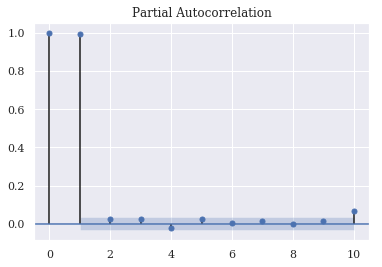

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf
fig = plot_pacf(res, lags=10, alpha=0.05)

Next the same analysis is applied to all the pair combinations importing function **coint_test_bulk** from **py_utility.py**:

**Step 1: Obtain fitted residuals to conduct ADF test (Stationarity Test)**

Let's do some EDA (exploratory data analysis) using a random pair (COP-XOM) to obtain preliminary regression results, plot the residuals and run ADF test.

Let's import now our tool from py_utility to test all the possible y,x pair combinations in our sample:

In [14]:
output = coint_test_bulk(df[['COP','CVX','SPY','XLE','XOM']], start,end, alpha=0.01, max_d=4)
output.loc[(output['Cointegrated']==True) & (output['diff']==0) ,:] #only show Cointegraed pairs

,y,x,diff,ADF Lags,ADF stat,ADF stat sm,1%CV,5%CV,10%CV,ADF p-value,Cointegrated
"(COP, SPY)",COP,SPY,0,5.0,-2.8,-2.8,-2.566,-1.941,-1.617,0.005,True
"(COP, XLE)",COP,XLE,0,4.0,-3.2,-3.2,-2.566,-1.941,-1.617,0.001,True
"(COP, XOM)",COP,XOM,0,4.0,-2.9,-2.9,-2.566,-1.941,-1.617,0.004,True
"(XLE, COP)",XLE,COP,0,4.0,-3.2,-3.2,-2.566,-1.941,-1.617,0.001,True
"(XLE, XOM)",XLE,XOM,0,5.0,-3.0,-3.0,-2.566,-1.941,-1.617,0.003,True
"(XOM, COP)",XOM,COP,0,4.0,-2.9,-2.9,-2.566,-1.941,-1.617,0.004,True
"(XOM, XLE)",XOM,XLE,0,5.0,-2.9,-2.9,-2.566,-1.941,-1.617,0.003,True


The combinations between XLE, XOM and COP price levels exhibit stationarity passing the ADF acid test with no unit root in their residuals assuming 1% significance level. The other pairs involving SPY and CVX need first differences to pass 
Engle Granger test. XOM-COP, XLE-XOM and XOM-XLE are particularly relevant as these pair combinations were also relevant in our preliminary IRF and Granger Causality Analysis.

- **Step 2: ECM using residuals from Step 1**

After confirming the pairs and degree of differences where we found cointegrated relationships i.e. residuals were stationary, now it's time to use the residuals to obtain the ECM (Equilibrium Correction Form). For this purpose, the pair COP-XOM has been selected due to its high statistical significance as aforementioned.

The relationship $$ y_t = \tau_e + \beta_e x_t + e_t$$ is a static equilibrium model encapsulated within the relationship between non-stationary (integrated) x and y with tau as a constant. However, using a dynamic regression model:

$$ y_t = \alpha y_{t-1} + \beta_0 + \beta_1 x_t + \beta_2 x_{t-1} + e_t$$ 

Adding and subtracting $$y_{t-1} , \beta_1 x_{t-1}$$

We obtain:

$$ y_t - y_{t-1}= \alpha y_{t-1} - y_{t-1} + \beta_0 +  \beta_1 x_t + \beta_2 x_{t-1} +\beta_1 x_{t-1}- \beta_1 x_{t-1} $$ 

Rearranging the terms, the ECM is obtained:
$$ \Delta Y_t  = \beta_ 1 \Delta X_t - (1-\alpha) e_{t-1} + \epsilon_t$$ 

where$$e_{t-1}$$are the residuals from the static equilibrium model lagged one period

This second step is helpful to understand if there's an equilibrim correction model effectively working i.e. the parameter $$-(1-\alpha)$$  is interpreted as the speed of correction towards the equilibrium level. Last but not least, this parameter significance will also aid to select which pair order is more relevant e.g. COP-XOM or XOM-COP.

In [16]:
# y= COP, X= XOM
constant = True
y_t = df['COP'].loc[start:end].dropna() # 
x_t = df['XOM'].loc[start:end].dropna()
if constant == True:
    x_t = add_constant(x_t) # add intercept = columns of 1s to x_t
# OLS regression: Static Equilibrium Model
ols = OLS(y_t, x_t).fit()  # validate result with statsmodels
res = ols.resid
# OLS regression: ECM Model
dy_t = df['COP'].loc[start:end].diff(1).dropna() # 
dx_t = df['XOM'].loc[start:end].diff(1).dropna()
if constant == True:
    dx_t = add_constant(dx_t) # add intercept = columns of 1s to x_t
dx_t['e_t_1'] = res.shift(1)
ols = OLS(dy_t, dx_t).fit()  # validate result with statsmodels
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    COP   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     2882.
Date:                Mon, 24 Jun 2019   Prob (F-statistic):               0.00
Time:                        15:54:08   Log-Likelihood:                -922.55
No. Observations:                3351   AIC:                             1851.
Df Residuals:                    3348   BIC:                             1869.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.006      0.843      0.399      -0.006       0.015
XOM            0.5560      0.007     75.924      0.000       0.542       0.570
e_t_1         -0.0038      0.002     -2.455      0.014      -0.007      -0.001
==============================================================================
Omnibus:                      368.833   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2604.260
Skew:                          -0.263   Prob(JB):                         0.00
Kurtosis:                       7.287   Cond. No.                         4.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
# y= XOM, X= COP
constant = True
lag = max_l # max lag for ADF
y_t = df['XOM'].loc[start:end].dropna() # 
x_t = df['COP'].loc[start:end].dropna()
if constant == True:
    x_t = add_constant(x_t) # add intercept = columns of 1s to x_t
# OLS regression: Static Equilibrium Model
ols = OLS(y_t, x_t).fit()  # validate result with statsmodels
res = ols.resid
# OLS regression: ECM Model
dy_t = df['XOM'].loc[start:end].diff(1).dropna() # 
dx_t = df['COP'].loc[start:end].diff(1).dropna()
if constant == True:
    dx_t = add_constant(dx_t) # add intercept = columns of 1s to x_t
dx_t['e_t_1'] = res.shift(1)
ols = OLS(dy_t, dx_t).fit()  # validate result with statsmodels
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    XOM   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     2887.
Date:                Mon, 24 Jun 2019   Prob (F-statistic):               0.00
Time:                        15:54:16   Log-Likelihood:                -2122.0
No. Observations:                3351   AIC:                             4250.
Df Residuals:                    3348   BIC:                             4268.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.966e-05      0.008      0.005      0.996      -0.015       0.015
COP            1.1376      0.015     75.918      0.000       1.108       1.167
e_t_1         -0.0054      0.002     -3.030      0.002      -0.009      -0.002
==============================================================================
Omnibus:                      560.150   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6027.448
Skew:                           0.455   Prob(JB):                         0.00
Kurtosis:                       9.507   Cond. No.                         8.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Testing the null hypothesis: $$Ho: -(1-\alpha)=0$$ The lagged residual coefficient p-value is not significant for significance levels below 2% for both pairs. In other words, we can assume that there's a correction mechanism helping the spread to reach long term equilibrium with a level of confidence of 97%. However, XOM-COP pair equilibrium correction mechanism seems to be more reliable than COP-XOM with a p-value below 1%.

##  7. Strategy Backtesting

Engle-Granger two-step procedure is necessary to ensure cointegration of series y and x along with stationarity of the spread:
    
$$ \epsilon_t = y_t - \tau_e - \beta_e x_t + $$
    
Nevertheless, In order to ﬁnd out the optimal entry and exit points, we need to model this spread or residual of the cointegration relationship. In this project a Ornstien-Uhlenbeck process is used to model the spread and identify entry and exit points.

In this way, after checking for stationarity, the spread can be modelled using OU (Ornstein-Uhlenbeck) process with SDE(stochastic differential equation):

$$ de_t  = -\theta (e_t -\mu_e) dt + \sigma dW_t$$

Where:
- speed of reversion: $$\theta$$ 
- equilibrium level: $$\mu$$
- scatter of diffusion: $$\sigma$$
- first difference of Wiener Process: $$dW_t$$

OU SDE solution:

$$ e_{t+\tau} = (1-e^{(-\theta \tau)}) \mu_e + e^{(-\theta \tau)} e_t + \epsilon_{t,\tau} $$

Transforming some terms:

$$ B = e^{(-\theta \tau)} $$
$$ C = \mu_e (1 - e^{-\theta \tau}) $$

Then it's possible to run the AR(1) regression:

$$ e_t = C + B e_{t-1} + \epsilon_{t,\tau} $$

To obtain C and B coefficients that allows us to calculate:

$$ \theta = - \frac{ln(B)}{\tau} $$

$$ \mu_e =  \frac{C}{1-B} $$

$$ \sigma_{OU} =  \sqrt{\frac{2 \theta Var(\epsilon_{t,\tau})}{1-e^{-2 \theta \tau}}}$$

$$ \sigma_{eq} \sim  \frac{\sigma_{OU}}{\sqrt{2 \theta}}$$

Then we can obtain the parameters required for our backtesting:

- Entry/Exit points: $$ \mu_e +/- \sigma_{eq} $$

- Approximated Speed of mean reversion: $$ \tau \sim\frac{ln(2)}{\theta}$$


In [18]:
def OU_Process_OLS(y,x, start, end, constant_=True):
    '''
    Returns OU Process OLS and entry/exit output calculated from AR(1) model using OU process:
    e_t = C + B*e_t_1 + eps_t_tau
    where e_t are the residuals from:
    y_t = constant + beta*x_t + e_t
    
    Params
    ------
    y = Dependent Variable e.g. security price level caused by x
    x = Independent Variable e.g. security price level causing y
    start = start date. Format 'YYYY-MM_DD'
    end = end date. Format 'YYYY-MM_DD' 
    constant = True. Constant present in OU process regression. 
    '''
    constant = True
    y_t = y.loc[start:end].dropna() # 
    x_t = x.loc[start:end].dropna()
    if constant == True:
        x_t = add_constant(x_t) # add intercept = columns of 1s to x_t
    # OLS regression: Static Equilibrium Model
    ols = OLS(y_t, x_t).fit()  # validate result with statsmodels
    res = ols.resid
    # OU SDE Solution Regression: e_t = C + B*et_1 + eps_t_tau
    constant = True
    res_t = res[1:] 
    res_t_1 = res.shift(1).dropna()
    if constant == True:
        x = add_constant(res_t_1) # add intercept = columns of 1s to x_t
    x.rename(columns={0: 'res_t_1'}, inplace=True)
    ols = OLS(res_t, x).fit()
    # Entry/Exit Params:
    mu_e = ols.params[0] / (1-ols.params[1]) # equilibrium level
    tau = 1/252 # daily data frequency 
    theta = - np.log(ols.params[1])/tau # speed of reversion
    half_l = np.log(2) / theta #  half life
    sigma_OU = np.sqrt( 2* theta * np.var(ols.resid) / (1- np.exp(-2*theta*tau)) ) # diffusion over small time scale (volatility coming from small ups and downs of BM)
    sigma_eq = sigma_OU / np.sqrt(2*theta)# use to determine exit/trading points = mu_e +/- sigma_eq
    # entry/exit points:
    ee_h = mu_e + sigma_eq
    ee_l = mu_e - sigma_eq
    df_out = {'spread':res,'mu_e':[mu_e],'tau':tau,'theta': theta,
                           'sigma_OU':sigma_OU,'sigma_eq':sigma_eq,
                           'ee_high':ee_h,'ee_low':ee_l}
    print('mu_e = ',mu_e)
    print('tau =', tau)
    print('theta = ', theta)
    print('sigma_OU = ', sigma_OU)
    print('sigma_eq = ', sigma_eq)
    print('high/low entry/exit points:', ee_l, ee_h)
    print('#'*50)
    print('############= OU Process Regression ##############')
    df_plot = pd.DataFrame({'res':res,'ee_h':np.repeat(ee_h,len(res)),'ee_l':np.repeat(ee_l,len(res)),
                            'mu_e':np.repeat(mu_e,len(res))}, index=res.index)
    df_plot.plot()
    return df_out
    

mu_e =  -0.14478079291299703
tau = 0.003968253968253968
theta =  1.370335080902171
sigma_OU =  7.275586845049403
sigma_eq =  4.394805337042781
high/low entry/exit points: -4.5395861299557785 4.250024544129784
##################################################
############= OU Process Regression ##############


dict_keys(['spread', 'mu_e', 'tau', 'theta', 'sigma_OU', 'sigma_eq', 'ee_high', 'ee_low'])

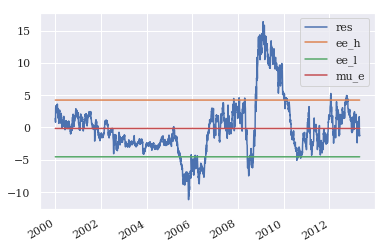

In [19]:
ou_params = OU_Process_OLS(df['XOM'], df['COP'], start, end, constant_=True)
ou_params.keys()

Using the mean and standard deviation from the fitted OU process to define position entry/exit thresholds, a normalized z-spread can be defined as:
$$  \frac{\hat e_t -\mu_e}{\sigma_{eq}} $$ 

In [20]:
def spread(y,x, start, end, constant_=True):
    '''
    Returns spread from regression:
    y = constant + 
    '''
    constant = True
    y_t = y.loc[start:end].dropna() 
    x_t = x.loc[start:end].dropna()
    if constant == True:
        x_t = add_constant(x_t) # add intercept = columns of 1s to x_t
    # OLS regression: Static Equilibrium Model
    ols = OLS(y_t, x_t).fit()  # validate result with statsmodels
    res = ols.resid
    return res

In [21]:
def spread_zscore(spread, mean=None, sigma=None):
    if (mean != None and sigma != None):
        return (spread - mean) / sigma
    else:
        return (spread - spread.mean()) / np.std(spread)

Text(0.5,1,'Spread - Z-Score')

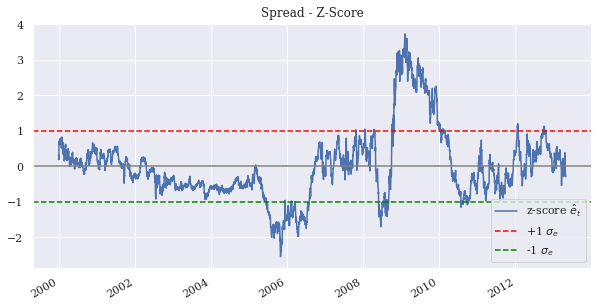

In [22]:
zs = spread_zscore(spread(df['XOM'], df['COP'], start, end, constant_=True))
zs.plot(figsize=(10,5))
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['z-score $\hat{e}_t$', '+1 $\sigma_e$', '-1 $\sigma_e$'], loc='lower right')
plt.axhline(0, color='grey')
plt.title('Spread - Z-Score')

### In-sample Backtesting

In [23]:
# Param Set Up
start_in =  '1999-12-31'
end_in = '2013-04-30'
start = start_in
end = end_in
sp = MRVectorBacktester(df['XOM'], df['COP'], df['XLE'], start, end, start_in, end_in, freq='daily', trans=None, ctf=0.0017, rf=0.02)
sp.run_strategy(sd=1,slip=1)

{'strat cum P&L': 0.7028,
 'cum perf vs bmk': -1.8823,
 'strat vol': 17.8633,
 'strat sharpe': 0.2268}

In [24]:
sp.perf_stats()

From 1999-12-31 to 2013-04-30


,Buy&Hold,Strategy,Benchmark
Statistics,,,
Gross_P&L,-69.149,75.5757,258.515
Net_P&L,-69.149,70.2844,258.515
Gross_CAGR,-8.43836,4.31002,10.0444
Net_CAGR,-8.43836,4.07102,10.0444
Net_Anual_Vol,27.9294,17.8633,35.8022
%_Positive,47.2,16.56,52.3
Skew,0.376387,-0.350431,-0.450842
Kurtosis,3.85613,12.7004,8.72357
Kurtosis PV,7.0673e-68,6.95384e-149,2.49846e-121


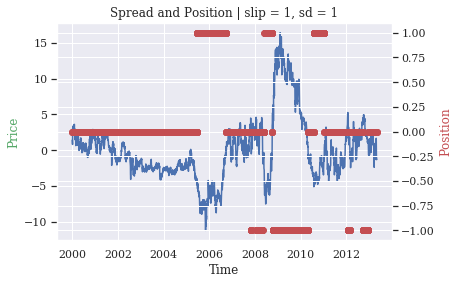

In [4]:
sp.plot_data()

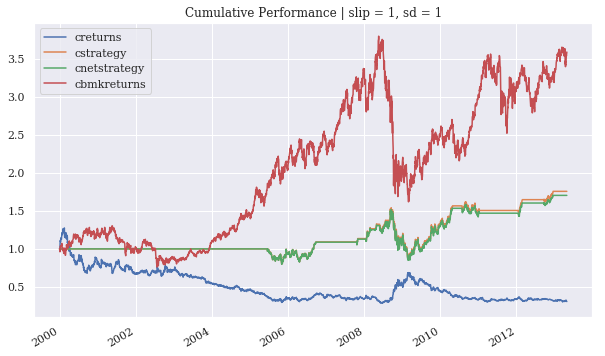

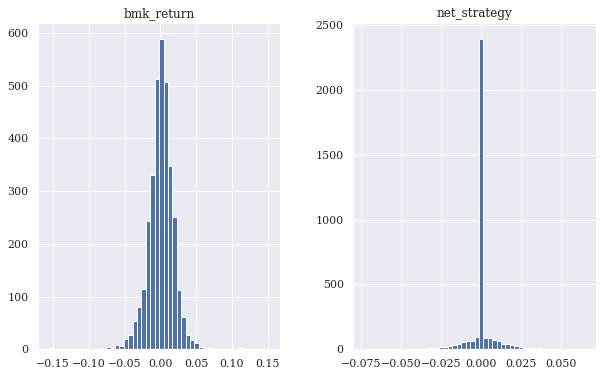

In [59]:
sp.plot_results()

   3 Worst DD 3 Worst DD Periods
0   43.847557           583 days
1   43.729513           542 days
2   43.712629           434 days
##################################################
       Rolling DrawDown Stats
count             3352.000000
mean                 4.605395
std                  8.736123
min                  0.000000
25%                  0.000000
50%                  0.169856
75%                  7.281299
max                 43.847557
##################################################


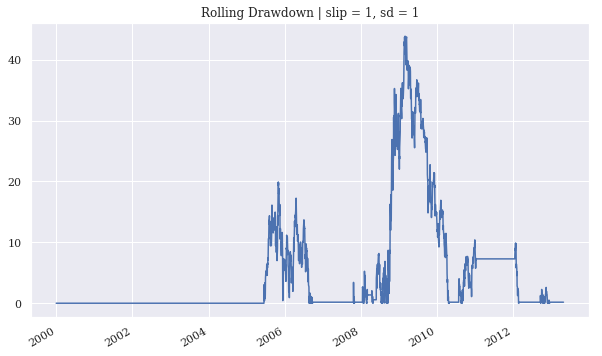

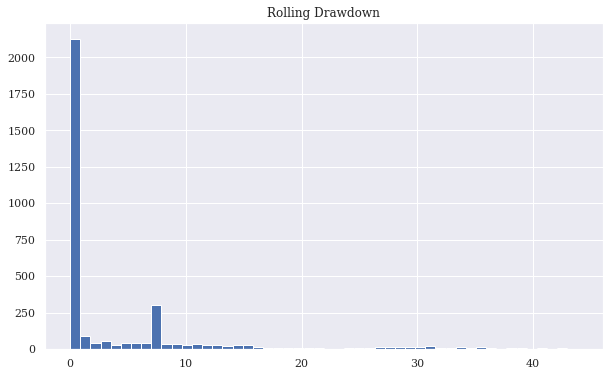

In [34]:
sp.plot_drawdown()

### Out-of-sample Backtesting

In [25]:
start_in =  '1999-12-31'
end_in = '2013-04-30'
start = '2013-05-01'
end = df.index[-1]
sp = MRVectorBacktester(df['XOM'], df['COP'], df['XLE'], start, end, start_in, end_in, freq='daily', trans=None, ctf=0.0017, rf=0.02)
sp.run_strategy(sd=1,slip=1)

{'strat cum P&L': -0.0078,
 'cum perf vs bmk': 0.1398,
 'strat vol': 31.0157,
 'strat sharpe': -0.0051}

In [26]:
sp.perf_stats()

From 2013-05-01 to 2018-12-31 00:00:00


,Buy&Hold,Strategy,Benchmark
Statistics,,,
Gross_P&L,-28.0717,0.410842,-14.7601
Net_P&L,-28.0717,-0.776966,-14.7601
Gross_CAGR,-5.64446,0.0723208,-2.77669
Net_CAGR,-5.64446,-0.137442,-2.77669
Net_Anual_Vol,32.0298,31.0157,24.5485
%_Positive,49.16,43.56,50
Skew,0.15933,-0.0481331,-0.197
Kurtosis,5.51833,6.41453,2.14086
Kurtosis PV,2.16854e-40,8.69362e-45,4.94747e-18


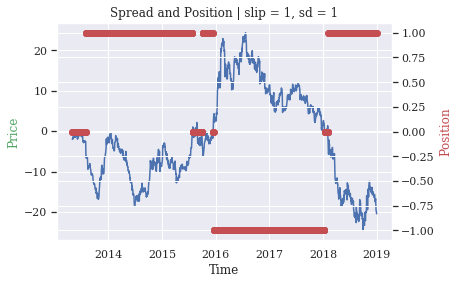

In [6]:
sp.plot_data()

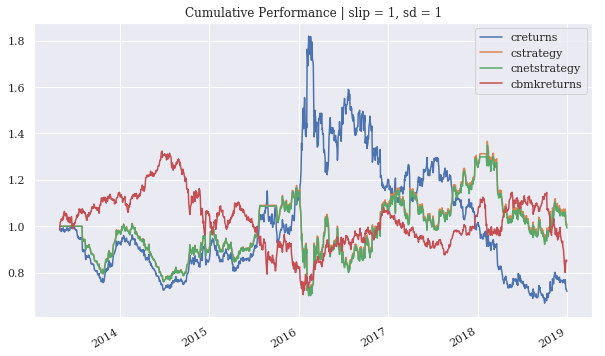

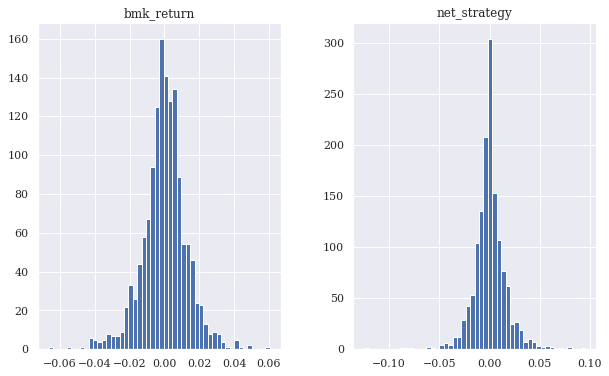

In [67]:
sp.plot_results()

   3 Worst DD 3 Worst DD Periods
0   39.944437           642 days
1   39.884351           516 days
2   39.280179           170 days
##################################################
       Rolling DrawDown Stats
count             1428.000000
mean                12.637265
std                  9.383030
min                  0.000000
25%                  4.414590
50%                 11.334560
75%                 21.089035
max                 39.944437
##################################################


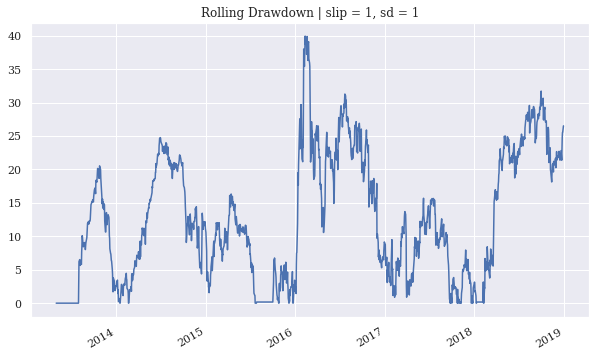

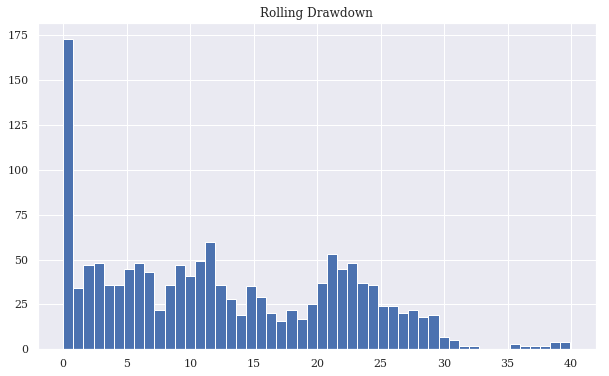

In [68]:
sp.plot_drawdown()

### Total Period

In [27]:
start_in =  '1999-12-31'
end_in = '2013-04-30'
start = '1999-12-31'
end = df.index[-1]
sp = MRVectorBacktester(df['XOM'], df['COP'], df['XLE'], start, end, start_in, end_in, freq='daily', trans=None, ctf=0.0017, rf=0.02)
sp.run_strategy(sd=1,slip=1)

{'strat cum P&L': 0.6896,
 'cum perf vs bmk': -1.3664,
 'strat vol': 22.6092,
 'strat sharpe': 0.1228}

In [28]:
sp.perf_stats()

From 1999-12-31 to 2018-12-31 00:00:00


,Buy&Hold,Strategy,Benchmark
Statistics,,,
Gross_P&L,-77.8094,76.297,205.598
Net_P&L,-77.8094,68.9614,205.598
Gross_CAGR,-7.61262,3.02697,6.05126
Net_CAGR,-7.61262,2.79694,6.05126
Net_Anual_Vol,29.2149,22.6092,32.8494
%_Positive,47.78,24.62,51.61
Skew,0.294759,-0.169296,-0.422532
Kurtosis,4.69188,11.2509,9.06787
Kurtosis PV,6.90399e-112,2.42352e-197,5.24133e-175


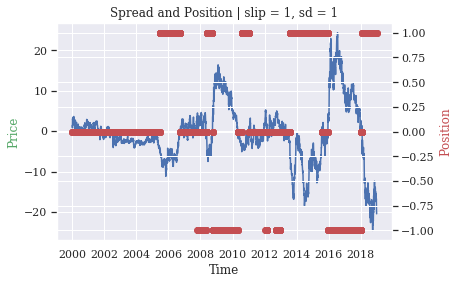

In [8]:
sp.plot_data()

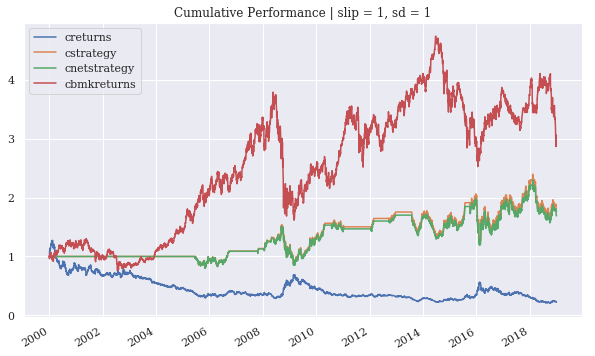

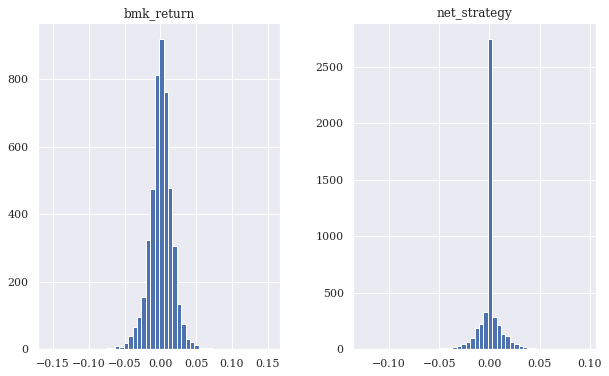

In [79]:
sp.plot_results()

   3 Worst DD 3 Worst DD Periods
0   43.847557           642 days
1   43.729513           583 days
2   43.712629           542 days
##################################################
       Rolling DrawDown Stats
count             4780.000000
mean                 7.010856
std                  9.660027
min                  0.000000
25%                  0.000000
50%                  1.385314
75%                 10.812117
max                 43.847557
##################################################


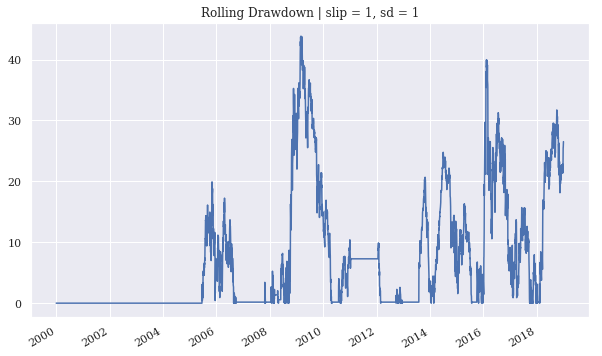

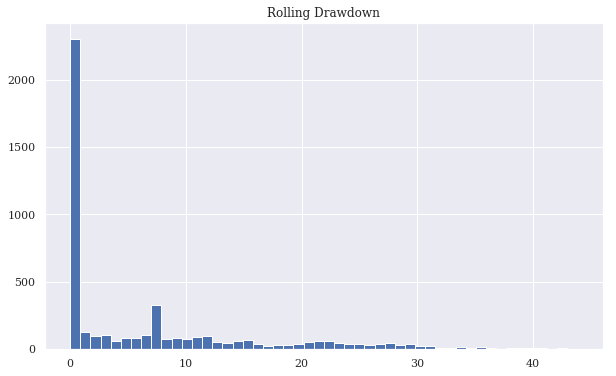

In [80]:
sp.plot_drawdown()

### Optimization

Taking the whole sample for both training and backtesting in order to optimize

In [29]:
start_in =  df.index[0]
end_in = df.index[-1]
start = start_in
end = end_in
sp = MRVectorBacktester(df['XOM'], df['COP'], df['XLE'], start, end, start_in, end_in, freq='daily', trans=None, ctf=0.0017, rf=0.02)
sp.run_strategy(sd=2)
sp.perf_stats()

From 1999-12-31 00:00:00 to 2018-12-31 00:00:00


,Buy&Hold,Strategy,Benchmark
Statistics,,,
Gross_P&L,-70.1116,133.941,205.598
Net_P&L,-70.1116,131.961,205.598
Gross_CAGR,-6.15422,4.57134,6.05126
Net_CAGR,-6.15422,4.5246,6.05126
Net_Anual_Vol,25.6754,13.7876,32.8494
%_Positive,47.68,9.75,51.61
Skew,0.281205,0.334777,-0.422532
Kurtosis,4.81181,35.9062,9.06787
Kurtosis PV,4.21281e-114,0,5.24133e-175


In [30]:
optimized = sp.optimize_parameters((1,6,0.5),(1,4,1),1)
optimized

C:\Users\Carlo\Desktop\BACKUP\CQF\LECTURES\Module 6 - Advance Electives\Project Time Series\Perf_Stats_Tools.py:101: RuntimeWarning: divide by zero encountered in double_scalars
  return (pl_CAGR(x)-rf)/(an_vol(x,freq))


([2, 1],
 {'strat cum P&L': 1.3196,
  'cum perf vs bmk': -0.7364,
  'strat vol': 13.7876,
  'strat sharpe': 0.3267})

In [31]:
sp.optimal_param_multiper((1,6,0.5),(1,4,1),ratio=1,n_split=3)

C:\Users\Carlo\Desktop\BACKUP\CQF\LECTURES\Module 6 - Advance Electives\Project Time Series\VecBacktester_spread.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['sma'] = mu
C:\Users\Carlo\Desktop\BACKUP\CQF\LECTURES\Module 6 - Advance Electives\Project Time Series\VecBacktester_spread.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['dist'] = data['price'] - data['sma']
C:\Users\Carlo\Desktop\BACKUP\CQF\LECTURES\Module 6 - Advance Electives\Project Time Series\VecBacktester_spread.py:162: SettingWithCopyWarning: 
A valu

             type  par1  par2       start         end      pl      vol  sharpe
0  Mean-Reversion     1     1  1999-12-31  2006-05-03  0.0057   9.3965  0.0075
1  Mean-Reversion     2     1  2006-05-04  2012-08-28  0.3077  16.8853  0.2557
2  Mean-Reversion     3     1  2012-08-29  2018-12-28  0.4936  23.7646  0.2745
Peformance Metrics for the period 1999-12-31 00:00:00 - 2018-12-31 00:00:00


C:\Users\Carlo\Desktop\BACKUP\CQF\LECTURES\Module 6 - Advance Electives\Project Time Series\VecBacktester_spread.py:422: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  return results.sort_index(by=rat, ascending=False)


,type,par1,par2,start,end,pl,vol,sharpe
1,Mean-Reversion,2.0,1.0,2006-05-04,2012-08-28,1.3196,13.7876,0.3267
0,Mean-Reversion,1.0,1.0,1999-12-31,2006-05-03,1.1396,17.8850,0.2271
2,Mean-Reversion,3.0,1.0,2012-08-29,2018-12-28,0.7439,10.2911,0.2865


In [32]:
# Optimal params: sd=2 and slip=1
sp.run_strategy(sd=optimized[0][0],slip=optimized[0][1])

{'strat cum P&L': 1.3196,
 'cum perf vs bmk': -0.7364,
 'strat vol': 13.7876,
 'strat sharpe': 0.3267}

In [33]:
sp.perf_stats()

From 1999-12-31 00:00:00 to 2018-12-31 00:00:00


,Buy&Hold,Strategy,Benchmark
Statistics,,,
Gross_P&L,-70.1116,133.941,205.598
Net_P&L,-70.1116,131.961,205.598
Gross_CAGR,-6.15422,4.57134,6.05126
Net_CAGR,-6.15422,4.5246,6.05126
Net_Anual_Vol,25.6754,13.7876,32.8494
%_Positive,47.68,9.75,51.61
Skew,0.281205,0.334777,-0.422532
Kurtosis,4.81181,35.9062,9.06787
Kurtosis PV,4.21281e-114,0,5.24133e-175


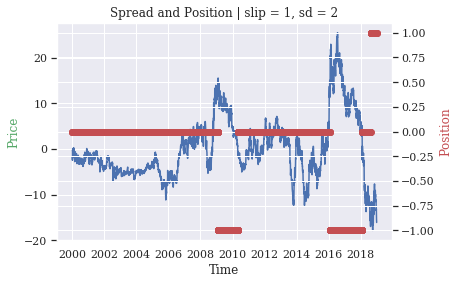

In [18]:
sp.plot_data()

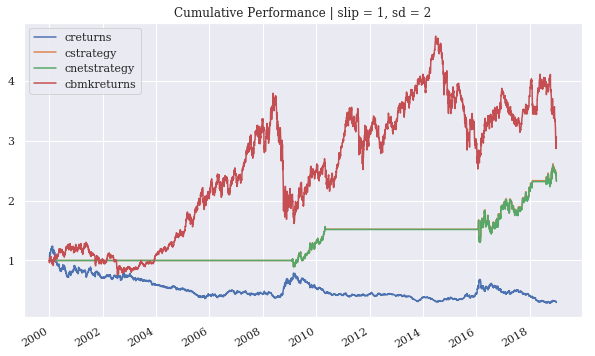

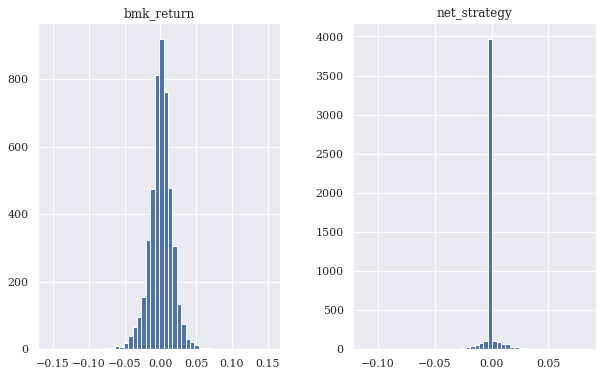

In [19]:
sp.plot_results()

   3 Worst DD 3 Worst DD Periods
0   22.112133          2095 days
1   21.854679           218 days
2   21.478680           191 days
##################################################
       Rolling DrawDown Stats
count             4780.000000
mean                 2.028875
std                  3.181234
min                  0.000000
25%                  0.000000
50%                  0.169856
75%                  2.994257
max                 22.112133
##################################################


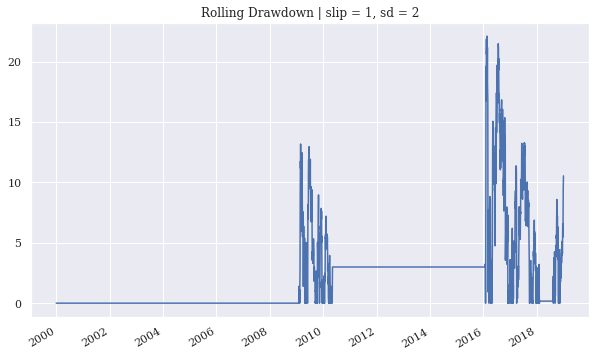

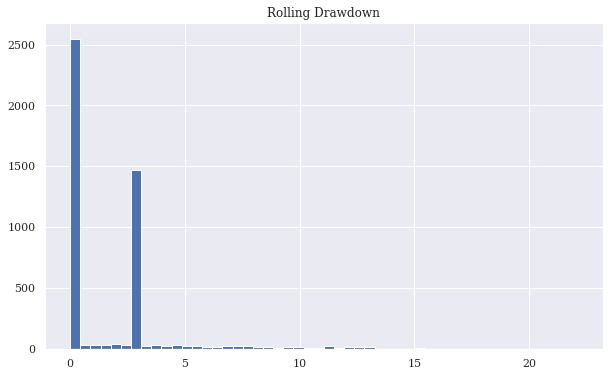

In [20]:
sp.plot_drawdown()

### Strategy - Multifactor Analysis

A comprehensive multifactor analysis is conducted using Fama-French framework and additional factors to control for macroeconomic and other literature effects.

In the same fashion as it was done in past sections, we conducted risk factor analysis for three periods: total period (2000-2018) as well as our in-sample (2000-2013) and out-of-sample (2013-2018).

                            OLS Regression Results                            
Dep. Variable:                     TR   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     43.40
Date:                Mon, 24 Jun 2019   Prob (F-statistic):           1.84e-63
Time:                        16:12:56   Log-Likelihood:                -2871.3
No. Observations:                1664   AIC:                             5761.
Df Residuals:                    1655   BIC:                             5809.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0426      0.034      1.266      0.2

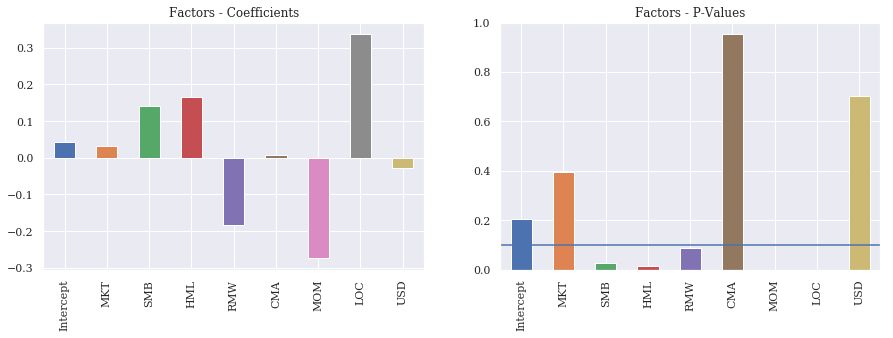

In [34]:
# IN-SAMPLE + OUT-OF-SAMPLE
start_in =  df.index[0]
end_in = df.index[-1]
start = df.index[0]
end = df.index[-1]
sp = MRVectorBacktester(df['XOM'], df['COP'], df['XLE'], start, end, start_in, end_in, freq='daily', trans=None, ctf=0.0017, rf=0.02)
sp.run_strategy(sd=1, slip=1)
# Only analyze periods where the strategy is open i.e. position is either long or short.
series = sp.results['net_strategy'].loc[(sp.results['position']==1) |(sp.results['position']==-1)]
bmk = sp.results['bmk_return'].loc[(sp.results['position']==1) |(sp.results['position']==-1)]
strategy_factor_analysis(series,bmk,freq='daily', US_factors=True)

Let's check now differences with in-sample and out-of-sample period risk factor exposures:

                            OLS Regression Results                            
Dep. Variable:                     TR   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     25.23
Date:                Mon, 24 Jun 2019   Prob (F-statistic):           1.97e-34
Time:                        16:14:48   Log-Likelihood:                -1349.3
No. Observations:                 729   AIC:                             2717.
Df Residuals:                     720   BIC:                             2758.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0218      0.058      0.377      0.7

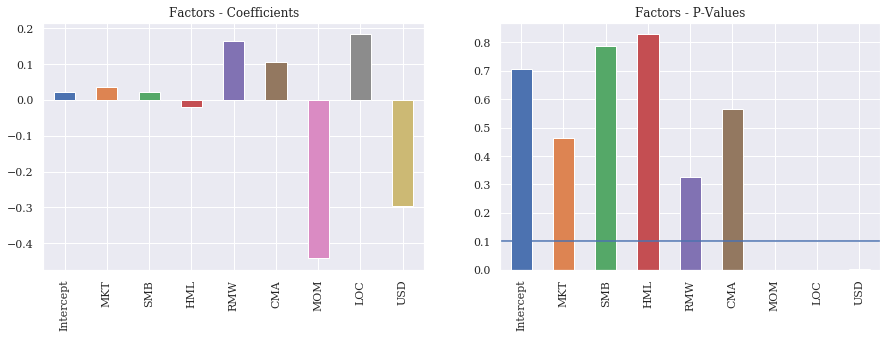

In [35]:
# IN-SAMPLE
start_in =  '1999-12-31'
end_in = '2013-04-30'
start = start_in
end = end_in
sp = MRVectorBacktester(df['XOM'], df['COP'], df['XLE'], start, end, start_in, end_in, freq='daily', trans=None, ctf=0.0017, rf=0.02)
sp.run_strategy(sd=1,slip=1)
# Only analyze periods where the strategy is open i.e. position is either long or short.
series = sp.results['net_strategy'].loc[(sp.results['position']==1) |(sp.results['position']==-1)]
bmk = sp.results['bmk_return'].loc[(sp.results['position']==1) |(sp.results['position']==-1)]
strategy_factor_analysis(series,bmk,freq='daily', US_factors=True)

                            OLS Regression Results                            
Dep. Variable:                     TR   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     12.96
Date:                Mon, 24 Jun 2019   Prob (F-statistic):           4.36e-18
Time:                        16:15:17   Log-Likelihood:                -2474.5
No. Observations:                1294   AIC:                             4967.
Df Residuals:                    1285   BIC:                             5014.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0070      0.046      0.153      0.8

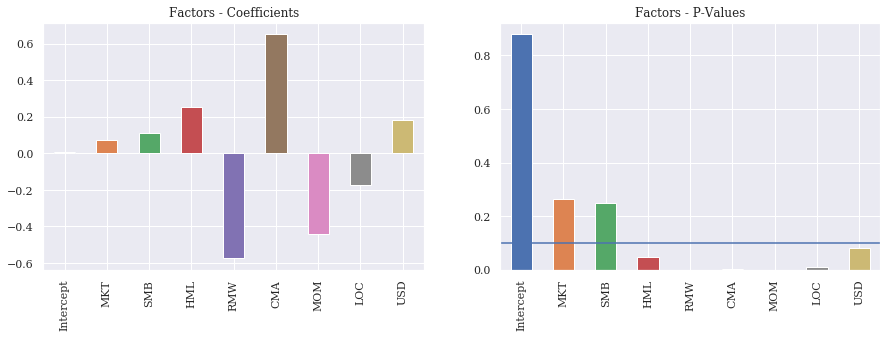

In [37]:
# OUT-OF-SAMPLE
start_in =  '1999-12-31'
end_in = '2013-04-30'
start = end_in
end = df.index[-1]
sp = MRVectorBacktester(df['XOM'], df['COP'], df['XLE'], start, end, start_in, end_in, freq='daily', trans=None, ctf=0.0017, rf=0.02)
sp.run_strategy(sd=1,slip=1)
# Only analyze periods where the strategy is open i.e. position is either long or short.
series = sp.results['net_strategy'].loc[(sp.results['position']==1) |(sp.results['position']==-1)]
bmk = sp.results['bmk_return'].loc[(sp.results['position']==1) |(sp.results['position']==-1)]
strategy_factor_analysis(series,bmk,freq='daily', US_factors=True)